# Machine Learning Project

#### Student names and numbers:

#####     Andrei Bostan   293104
#####     Daniel Railean  294241
#####     Ion Creciun     293166

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


In [6]:
# Import all necessary modules here:
# !pip install nltk
# !pip install librosa
import matplotlib.pyplot as plt
import numpy as np

import ast
from PIL import Image
import os
import pandas as pd
import numpy as np
# !{sys.executable} -m pip install difPy
from difPy import dif

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,ElasticNet
from sklearn import ( decomposition,
                     metrics, preprocessing)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ( decomposition, 
                     metrics,  preprocessing)
from numpy.random import seed
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import librosa
import librosa.display
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
%matplotlib inline




## 1. The IceCat Dataset - All of us (Ion, Andrei, Daniel)

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.

### command to install ffmpeg in PowerShell

#### first install choco by using instructions from below

#### using powershell and open as admin
``` console
Set-ExecutionPolicy Bypass -Scope Process -Force; [System.Net.ServicePointManager]::SecurityProtocol = [System.Net.ServicePointManager]::SecurityProtocol -bor 3072; iex ((New-Object System.Net.WebClient).DownloadString('https://community.chocolatey.org/install.ps1'))
```

#### then install ffmpeg
``` console
choco install ffmpeg
```

##### The code below will resize all Images to be 100x100, keeping the original aspect ratio and filling the margins with white in case they need offset
##### This will get all the images to a similar format which is better for the model to run on
##### This can be skipped if you don't want to wait, as we already provide them


In [2]:
# change directory path as necessary
originalDirectory = 'IceCat/images/'
resizedDirectory = 'IceCatResized/'
# creates a new folder for the resized images
os.system('mkdir ' + resizedDirectory[:-1])

# create list of all files in directory     
folder_files = [filename for filename in os.listdir(originalDirectory)]  
for filename in folder_files: 
    # check if the file is accesible
    if not os.path.isdir(originalDirectory + filename):
        # run ffmpeg to scale down to 100x100 preserving ratio
        # add padding to non-square images to make them square
        # adds them to the new folder
        os.system('ffmpeg -i ' + originalDirectory + filename  + ' -vf "scale=w=100:h=100:force_original_aspect_ratio=1,pad=100:100:(ow-iw)/2:(oh-ih)/2:color=white" ' + resizedDirectory  + filename )        
        

##### use difPy to find images that are highly similar (mostly repeating) and delete them as they are a cause of possible overfitting
##### This step can be skipped as well since it takes a lot of time to process this


In [3]:
dif(resizedDirectory, similarity="high", show_progress=True, show_output=False, delete=True, silent_del=True)

In [4]:
# find the images that got deleted
originalImages = []
imagesAfterDeletion = []
deleted = []

directories = [originalDirectory, resizedDirectory]

for i in range(len(directories)):
    directory = directories[i]
    folder_files = [filename for filename in os.listdir(directory)]  
    for filename in folder_files:
        if not os.path.isdir(directory + filename):
            file_number = filename.split('.')[0]
            if i == 0:
                originalImages.append(int(file_number))
            else: 
                imagesAfterDeletion.append(int(file_number))
        
deleted = list(set(originalImages) - set(imagesAfterDeletion))


In [5]:
print(str(len(deleted)) + ' files got deleted')

0 files got deleted


##### This code will run through the data set and delete the images and labels that got deleted during the data cleaning in the previous steps, since the actual data got deleted, the labels have no business being there. It also get rids of the color-image combinations that are less then 10 images, as they would just be extra noise and would rather be replaced with colors that come up more often. We also remove the "transparent" and "multicolor" labeled photos, as they seem to be just white, noisy photos that a real person would not associate at all

In [6]:
import ast
with open("IceCat/colors.txt","r") as file:
    colors = ast.literal_eval(file.read())
    
# put colors and images in a dataframe
# remove the color-image combinations that got deleted
df = []
for image in colors:
    df.append(list(image))
    
df = pd.DataFrame(df, columns = ["Name","Color"])
df = df[~df["Name"].isin(deleted)]

# get unique colors
# delete the color-image combinations that are represented by less then 10 images
groups = df.groupby("Color")['Name'].nunique()

x = []
y = []
for (index,data) in enumerate(groups):
    if(data < 10):
        x.append(data)
        y.append(groups.index[index])
        
df = df[~df["Color"].isin(y)]

# delete the transparent images
df = df[~df["Color"].isin(['Transparent'])]
df = df[~df["Color"].isin(['Multicolor'])]

#delete all multiple colors
df = df[~df["Color"].str.contains(",")]
df = df[~df["Color"].str.contains("Multicolour")]
df = df[~df["Color"].str.contains("Assorted colours")]


# figure out which similar dictionary do we use
similar = {
    "Brown" : ["Beige","Wood"],
    "Blue": ["turquoise"],
    "Purple" : [ "Violet"],
    "Silver" : ["Aluminium","Metallic","Stainless steel"],
    "Yellow" : ["Gold"]
}


# # replace colors as dictated by the similarity dictionary above
for key in similar:
    for color in similar[key]:
        df.loc[df["Color"].str.lower() == color.lower(), 'Color'] = key.capitalize()

print(df.groupby("Color")['Name'].nunique())

Color
Black     1034
Blue       485
Brown      179
Green      217
Grey       392
Orange      89
Pink        50
Purple      60
Red        276
Silver     187
White      694
Yellow     218
Name: Name, dtype: int64


In [7]:
# convert images to pixel arrays
imagesAsPixelArrays = []

folder_files = [filename for filename in os.listdir(resizedDirectory)]  

for filename in df["Name"]:
    im = np.array(Image.open(resizedDirectory + str(filename) + '.jpg'))
    arr = (im.flatten())
    imagesAsPixelArrays.append(arr)
    
imagesAsPixelArrays = np.array(imagesAsPixelArrays)

##### GridSearchCV was used to go through multiple combinations of hyperparams to get the best accuracy 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':range(3,16,2),
               'metric' : ['minkowski','euclidean']}

grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, refit = True, return_train_score=True, verbose=4)

# Load the data and divide into train and test
X_train, X_test, y_train, y_test = train_test_split(imagesAsPixelArrays, df['Color'], random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=69)
print(parameters)
print(len(X_train),len(X_test))
grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_val, y_val)))

print("Best parameter: {}".format(grid_search.best_params_))

print("Best cross-validation score: {}".format(grid_search.best_score_))

print("Best estimator: {}".format(grid_search.best_estimator_))





{'n_neighbors': range(3, 16, 2), 'metric': ['minkowski', 'euclidean']}
2182 971
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END metric=minkowski, n_neighbors=3;, score=(train=0.766, test=0.568) total time=   0.6s
[CV 2/5] END metric=minkowski, n_neighbors=3;, score=(train=0.762, test=0.554) total time=   0.6s
[CV 3/5] END metric=minkowski, n_neighbors=3;, score=(train=0.765, test=0.583) total time=   0.5s
[CV 4/5] END metric=minkowski, n_neighbors=3;, score=(train=0.763, test=0.573) total time=   0.6s
[CV 5/5] END metric=minkowski, n_neighbors=3;, score=(train=0.772, test=0.571) total time=   0.7s
[CV 1/5] END metric=minkowski, n_neighbors=5;, score=(train=0.698, test=0.572) total time=   0.6s
[CV 2/5] END metric=minkowski, n_neighbors=5;, score=(train=0.686, test=0.556) total time=   0.8s
[CV 3/5] END metric=minkowski, n_neighbors=5;, score=(train=0.695, test=0.557) total time=   0.6s
[CV 4/5] END metric=minkowski, n_neighbors=5;, score=(train=0.694, test=0.5

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


knn = KNeighborsClassifier(n_neighbors=3,metric="minkowski")
knn.fit(X_train, y_train)

print("Training Prediction: {}".format(knn.score(X_train,y_train)))

print("Test Prediction: {}".format(knn.score(X_test,y_test)))


Training Prediction: 0.7745187901008249
Test Prediction: 0.607621009268795


## 2. Flights Departing from NYC - Ion + Andrei - (e), (i) + Daniel (j)

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

In [2]:
#a
FOLDER  = "NYC_Flights/"

airlines_df = pd.read_csv(FOLDER + "airlines.csv")
airports_df = pd.read_csv(FOLDER + "airports.csv")
flights_df = pd.read_csv(FOLDER + "flights.csv")
planes_df = pd.read_csv(FOLDER + "planes.csv")
weather_df = pd.read_csv(FOLDER + "weather.csv")

In [12]:
airlines_df[0:5]

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


In [13]:
airports_df[0:5]

,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5.0,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6.0,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6.0,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5.0,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5.0,A,America/New_York


In [14]:
flights_df[0:5]

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


In [15]:
planes_df[0:5]

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


In [16]:
weather_df[0:5]

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

In [17]:
weather_df['temp'] = weather_df.apply(lambda x: (x['temp']-32)* 5/9 ,axis=1)
weather_df['dewp'] = weather_df.apply(lambda x: (x['dewp']-32)* 5/9 ,axis=1)

**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

[]

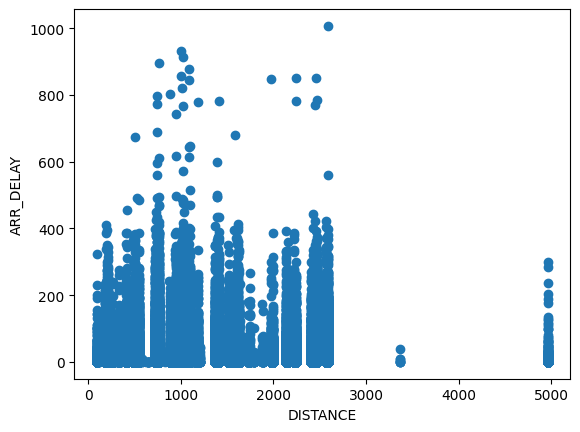

In [18]:
data = flights_df.loc[:,["arr_delay","distance"]].dropna()
# data = data.fillna(0)
X = data["distance"]
y = data["arr_delay"]
y[y<0] = 0
# y = y.fillna(0)
plt.scatter(X,y)
plt.xlabel("DISTANCE")
plt.ylabel("ARR_DELAY")
plt.plot()

In [19]:
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [20]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [21]:

ODS = LinearRegression()

ODS.fit(X_train, y_train)

LinearRegression()

R^2 on train data is 4.148259988234759e-05 and on test data is 9.54509296059447e-05


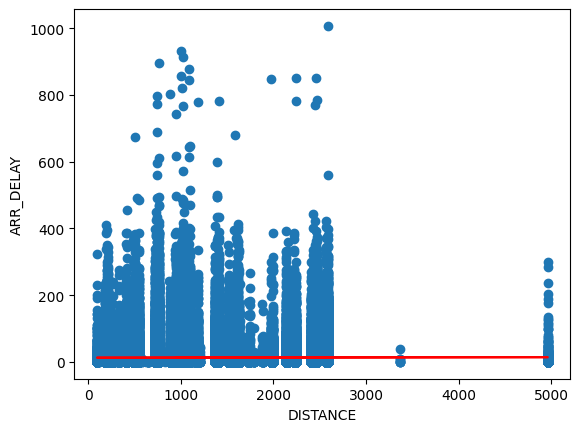

In [22]:
print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train), 
                                                              ODS.score(X_test,y_test)))
plt.scatter(X,y)
y_predict = ODS.predict(X_test)
plt.xlabel("DISTANCE")
plt.ylabel("ARR_DELAY")
plt.plot(X_test,y_predict,color='red')
plt.show()
# #SINCE R2 is quite low, we can say that departure distance does not predict arrival delay
# When replacing negative values, a lower prediction is made

**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

[]

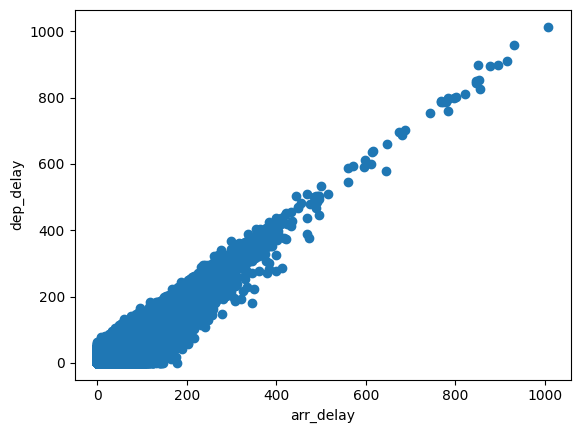

In [23]:
data = flights_df.loc[:,["dep_delay","arr_delay"]].dropna()

#NA is most frequent and thus mode is not a solution

X = data["arr_delay"]
y = data["dep_delay"]
X[X<0] = 0
y[y<0] = 0

plt.scatter(X,y)
plt.xlabel("arr_delay")
plt.ylabel("dep_delay")
plt.plot()

In [24]:
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)


R^2 on train data is 0.8668469275898878 and on test data is 0.8694998794928759


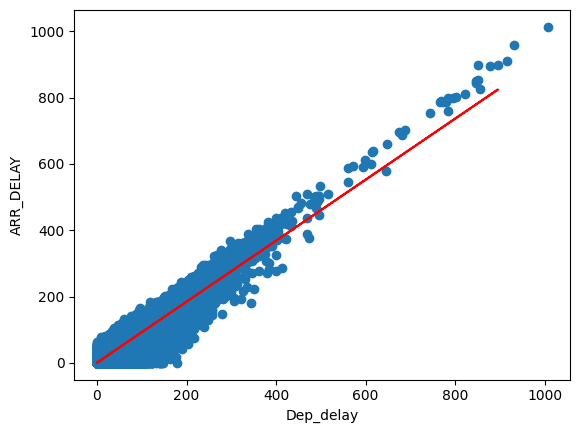

In [25]:
ODS = LinearRegression()

ODS.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train), 
                                                              ODS.score(X_test,y_test)))

plt.scatter(X,y)
y_predict = ODS.predict(X_test)
plt.xlabel("Dep_delay")
plt.ylabel("ARR_DELAY")
plt.plot(X_test,y_predict,color='red')
plt.show()

#Difference between replacing with mean and drop are not that big, 1 percent.

**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

In [26]:
flights_copy = flights_df.copy()
flights_copy.isnull().any()

year         False
month        False
day          False
dep_time      True
dep_delay     True
arr_time      True
arr_delay     True
carrier      False
tailnum       True
flight       False
origin       False
dest         False
air_time      True
distance     False
hour          True
minute        True
dtype: bool

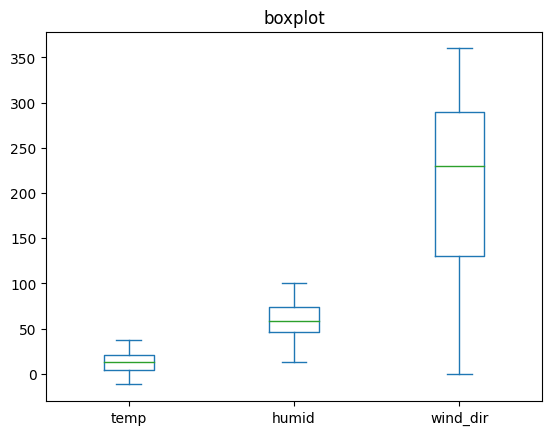

In [27]:
# drop weather NAs, as they are too important to replace
weather_df.dropna(inplace=True)
ax = weather_df[['temp', 'humid', 'wind_dir']].plot(kind='box', title='boxplot')
plt.show()

6.90468 24.16638 -3.4523400000000004


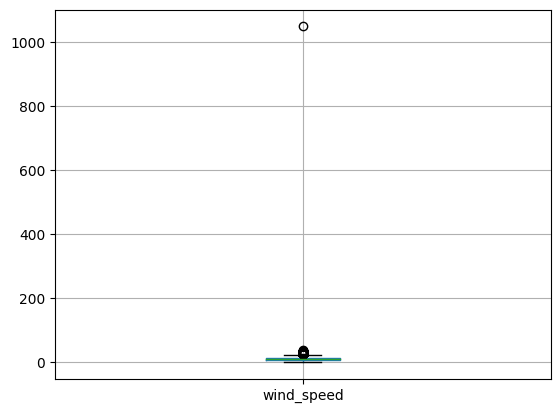

In [28]:
weather_df.boxplot(column=['wind_speed']) 
wind_speed_arr = weather_df.loc[:,"wind_speed"].values
# finding the 1st quartile
q1 = np.quantile(wind_speed_arr, 0.25)

# finding the 3rd quartile
q3 = np.quantile(wind_speed_arr, 0.75)
med = np.median(wind_speed_arr)
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

outliers = wind_speed_arr[(wind_speed_arr < lower_bound) | (wind_speed_arr > upper_bound)]
outliers.sort()
weather_df = weather_df.loc[weather_df['wind_speed'] != outliers[-1]]
# there is an obvious outlier that will ruin the plot visualisation, so we are deleting it

<AxesSubplot: >

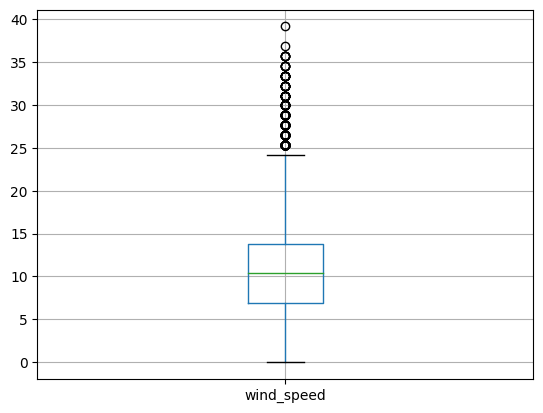

In [29]:
weather_df.boxplot(column=['wind_speed']) 
# got rid of the outlier and redidd the boxlplot

<AxesSubplot: >

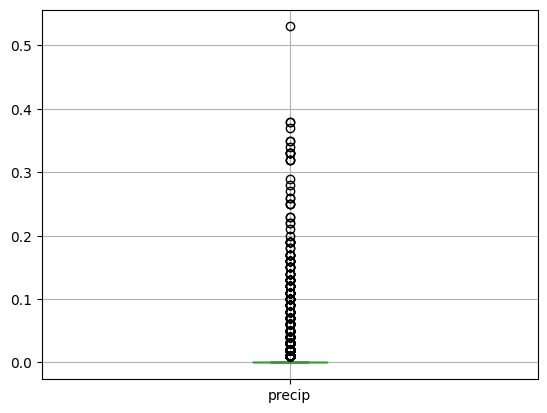

In [30]:
weather_df.boxplot(column=['precip']) 

<AxesSubplot: >

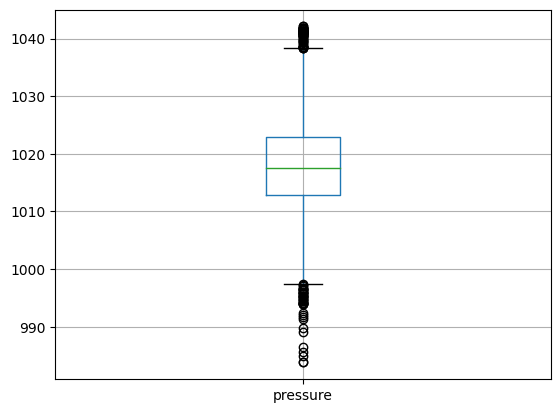

In [31]:
weather_df.boxplot(column=['pressure']) 

<AxesSubplot: >

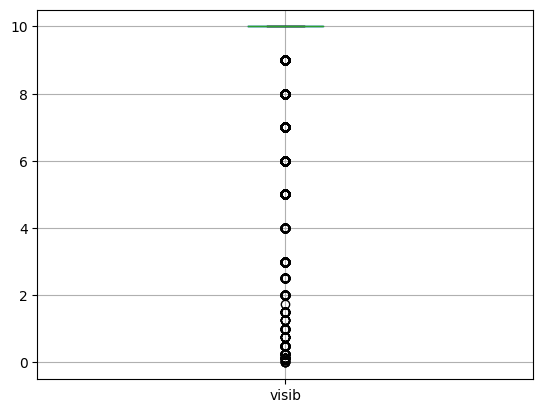

In [32]:
weather_df.boxplot(column=['visib'])
# interesting to see that any visibility outside the normal one is considered an outlier,
# rerepsenting that on most ocassions, the visibility is normal at 10 miles

In [33]:
import math

weather = weather_df.copy()
new_time_hour = []

# change R stuff to python date
for i, row in weather.iterrows():
    time_hour_val = np.datetime64(weather.at[i,'time_hour'])
    new_time_hour.append(time_hour_val)
    # weather.at[i,'time_hour'] = time_hour_val
weather['time_hour'] = new_time_hour

# get rid of NAs in date and time
flights_copy.dropna(subset=['year', 'month', 'day', 'hour'], inplace=True)
new_time_hour = []

# create new date format for flights to coincide with weather
for i, row in flights_copy.iterrows():
    y = flights_copy.at[i,'year'].astype(str)
    m = flights_copy.at[i,'month'].astype(str).zfill(2)
    d = flights_copy.at[i,'day'].astype(str).zfill(2)
    h = str(math.floor(flights_copy.at[i,'hour'])).zfill(2)

    if h == "24" :
        h = "00"

    dateTimeFormat = y + '-' + m + '-' + d + 'T' + h
    dt_time_hour = np.datetime64(dateTimeFormat)
    new_time_hour.append(dt_time_hour)

flights_copy['time_hour'] = new_time_hour



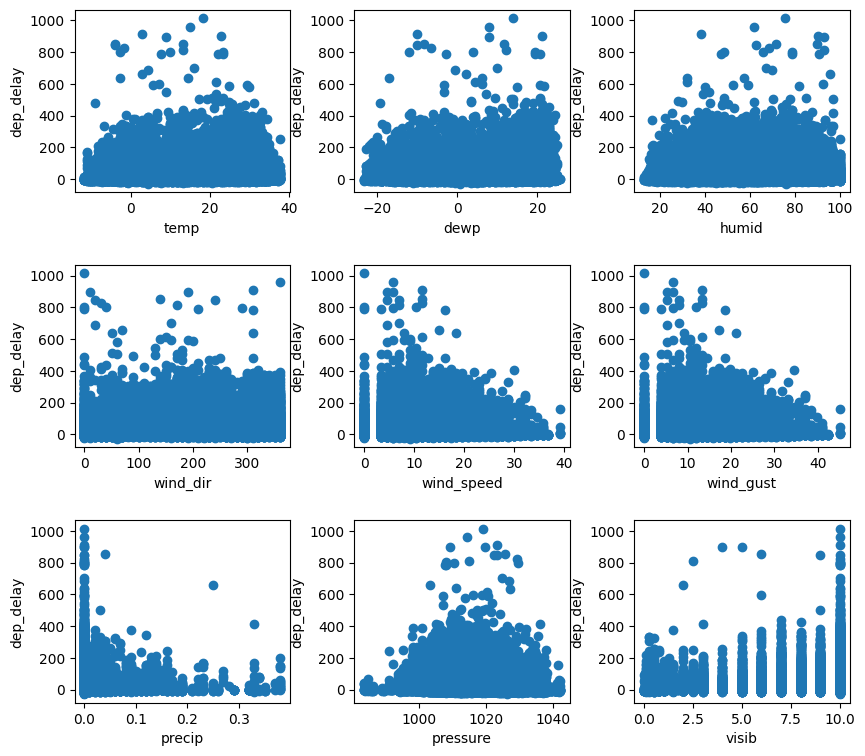

In [34]:
# merge flights with weather and plot the diferent phenomenones
merged_flights_weather = flights_copy.merge(weather, how='inner', on=['origin', 'time_hour'])

weather_phenomena = ['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib']
  
fig = plt.figure(figsize=(10, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot data by looping through arrays of variables and list of colors
y = merged_flights_weather["dep_delay"]
y = np.array(y).reshape(-1,1)

whi = 0
for i in range(3):
  for j in range(3):
    X = merged_flights_weather[weather_phenomena[whi]]
    X = np.array(X).reshape(-1,1)
    ax = fig.add_subplot(3, 3, whi+1)
    ax.scatter(X, y)
    ax.set_ylabel('dep_delay')
    ax.set_xlabel(weather_phenomena[whi])

    whi += 1

In [35]:
all_features = merged_flights_weather.loc[:,['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib']]
all_features.values

array([[   4.4 ,   -3.3 ,   57.33, ...,    0.  , 1011.9 ,   10.  ],
       [   4.4 ,   -3.3 ,   57.33, ...,    0.  , 1011.9 ,   10.  ],
       [   4.4 ,   -3.3 ,   57.33, ...,    0.  , 1011.9 ,   10.  ],
       ...,
       [  17.8 ,   13.3 ,   74.94, ...,    0.  , 1016.  ,   10.  ],
       [  17.8 ,   13.3 ,   74.94, ...,    0.  , 1016.  ,   10.  ],
       [  18.9 ,   12.2 ,   65.07, ...,    0.  , 1015.6 ,   10.  ]])

In [36]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,ElasticNet,ElasticNetCV

X = all_features.values

# OLS
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
ODS = LinearRegression()
ODS.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format( ODS.score(X_train, y_train), 
                                                                ODS.score(X_test,y_test)))

R^2 on train data is 0.02163077380196743 and on test data is 0.02598151616289912


(100, 9)
(100, 9)
alhpa = 1e-10
R^2 on train data is 0.024554323569018988 and on test data is 0.02018976627170077
alhpa = 1.2618568830660184
R^2 on train data is 0.01972372526725419 and on test data is 0.017079561054103687
alhpa = 10000000000.0
R^2 on train data is 8.548162178101393e-12 and on test data is -3.313205696064969e-05
R^2 on train data is 0.024546039040011403 and on test data is 0.020219468178433897


array([ 1.99391328e-01,  1.46212655e-01, -4.83236466e-02, -1.09644804e-02,
        2.42166180e-01,  2.10436556e-01,  8.19772008e+01, -2.49267466e-01,
       -7.80378298e-01])

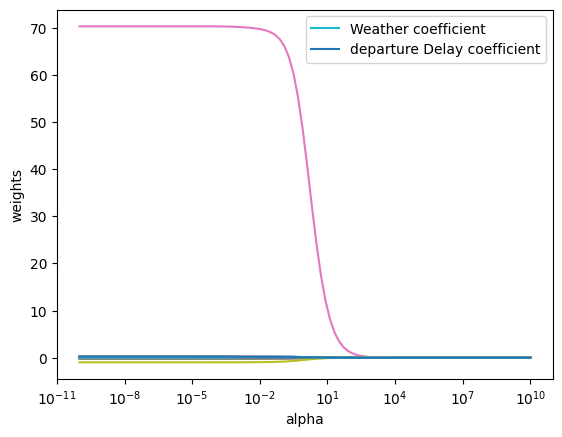

In [37]:
# RIDGE
alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []
y = y.flatten()
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

print(np.shape(coefs))
weather_coefficients = [coef[0] for coef in coefs]
depDelay_coefficients = [coef[1] for coef in coefs]
print(np.shape(coefs))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.plot(alphas, weather_coefficients, label="Weather coefficient")
ax.plot(alphas, depDelay_coefficients, label="departure Delay coefficient")
ax.set_xscale('log')
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
for alpha in [alphas[0], alphas[50], alphas[-1]]:
    ridge = Ridge(normalize=True, alpha=alpha)
    ridge.fit(X_train, y_train)
    print("alhpa = {}".format(alpha))
    print("R^2 on train data is {} and on test data is {}".format(ridge.score(X_train, y_train), 
                                                              ridge.score(X_test,y_test)))
ridgecv = RidgeCV(alphas = alphas, normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_
print("R^2 on train data is {} and on test data is {}".format(ridgecv.score(X_train, y_train), 
                                                              ridgecv.score(X_test,y_test)))
ridgecv.coef_

(100, 9)
R^2 on train data is 0.024554317312245333 and on test data is 0.020189935836275374


temp          1.374728e-01
dewp          2.165698e-01
humid        -6.977031e-02
wind_dir     -1.137087e-02
wind_speed    4.885317e-01
wind_gust     7.257918e-14
precip        8.312480e+01
pressure     -2.542046e-01
visib        -8.185862e-01
dtype: float64

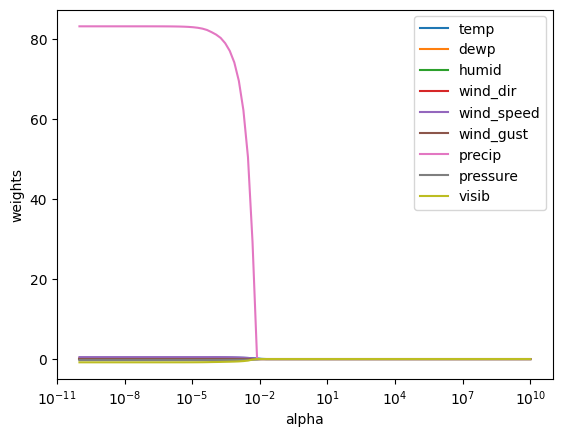

In [38]:
#LASSO
# #Lasso
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)
weather_coefficients0 = [coef[0] for coef in coefs]
weather_coefficients1 = [coef[1] for coef in coefs]
weather_coefficients2 = [coef[2] for coef in coefs]
weather_coefficients3 = [coef[3] for coef in coefs]
weather_coefficients4 = [coef[4] for coef in coefs]
weather_coefficients5 = [coef[5] for coef in coefs]
weather_coefficients6 = [coef[6] for coef in coefs]
weather_coefficients7 = [coef[7] for coef in coefs]
weather_coefficients8 = [coef[8] for coef in coefs]

print(np.shape(coefs))
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, weather_coefficients0, label="temp")
ax.plot(alphas, weather_coefficients1, label="dewp")
ax.plot(alphas, weather_coefficients2, label="humid")
ax.plot(alphas, weather_coefficients3, label="wind_dir")
ax.plot(alphas, weather_coefficients4, label="wind_speed")
ax.plot(alphas, weather_coefficients5, label="wind_gust")
ax.plot(alphas, weather_coefficients6, label="precip")
ax.plot(alphas, weather_coefficients7, label="pressure")
ax.plot(alphas, weather_coefficients8, label="visib")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train), 
                                                              lassocv.score(X_test,y_test)))
pd.Series(lasso.coef_, index=weather_phenomena)

In [39]:
#Elastic Net
elasticNet = ElasticNet(alpha=1)
elasticNet.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(elasticNet.score(X_train, y_train), 
                                                              elasticNet.score(X_test,y_test)))

R^2 on train data is 0.02321700733343568 and on test data is 0.01934571987726319


**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

In [40]:
data = flights_df.merge(planes_df, on='tailnum', how='left')
data = data.loc[:,["year_y","dep_delay","arr_delay"]]
y = data.loc[:,["year_y"]].values
X = data.loc[:,["arr_delay","dep_delay"]].values
X[X[:,0]<0] = 0
X[X[:,0]<0] = 0
y_mode = data.loc[:,['year_y']].mode()['year_y'][0]
np.nan_to_num(y,copy=False,nan=y_mode)

X_mode_arr = data.loc[:,['arr_delay']].mean()
np.nan_to_num(X[:,0],copy=False,nan=X_mode_arr)
X_mode_dep = data.loc[:,['dep_delay']].mean()
np.nan_to_num(X[:,1],copy=False,nan=X_mode_dep)

array([ 2.,  4.,  2., ...,  0.,  0., 80.])

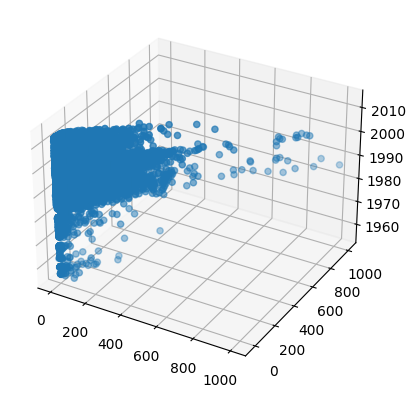

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1],y);

In [42]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
ODS = LinearRegression()
ODS.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train), 
                                                              ODS.score(X_test,y_test)))

#By doing OLS we can conclude that Plane Year manufacture is not associated with departure delay

R^2 on train data is 0.0008752974925070323 and on test data is 0.000717181382787091


#### Ridge Regression

In [43]:

alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []
y = y.flatten()
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
arrDelay_coefficients = [coef[0] for coef in coefs]
depDelay_coefficients = [coef[1] for coef in coefs]

Text(0, 0.5, 'weights')

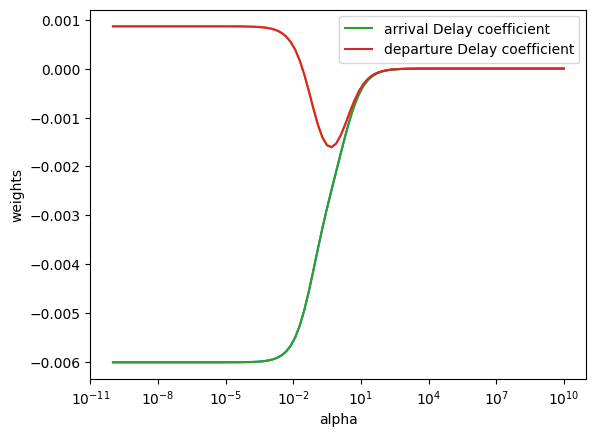

In [44]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.plot(alphas, arrDelay_coefficients, label="arrival Delay coefficient")
ax.plot(alphas, depDelay_coefficients, label="departure Delay coefficient")
ax.set_xscale('log')
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [45]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
for alpha in alphas:
    ridge = Ridge(normalize=True, alpha=alpha)
    ridge.fit(X_train, y_train)
    print("alhpa = {}".format(alpha))
    print("R^2 on train data is {} and on test data is {}".format(ridge.score(X_train, y_train), 
                                                              ridge.score(X_test,y_test)))

alhpa = 1e-10
R^2 on train data is 0.0006758813133509456 and on test data is 0.000999752720716729
alhpa = 1.592282793341094e-10
R^2 on train data is 0.0006758813133509456 and on test data is 0.0009997527206978551
alhpa = 2.5353644939701164e-10
R^2 on train data is 0.0006758813133506125 and on test data is 0.000999752720667768
alhpa = 4.03701725859655e-10
R^2 on train data is 0.0006758813133509456 and on test data is 0.0009997527206195844
alhpa = 6.428073117284319e-10
R^2 on train data is 0.0006758813133509456 and on test data is 0.000999752720542868
alhpa = 1.0235310218990269e-09
R^2 on train data is 0.0006758813133509456 and on test data is 0.0009997527204206325
alhpa = 1.6297508346206469e-09
R^2 on train data is 0.0006758813133506125 and on test data is 0.0009997527202262324
alhpa = 2.595024211399732e-09
R^2 on train data is 0.0006758813133509456 and on test data is 0.0009997527199163692
alhpa = 4.132012400115335e-09
R^2 on train data is 0.0006758813133508346 and on test data is 0.00

In [46]:
ridgecv = RidgeCV(alphas = alphas, normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.030538555088334123

In [47]:
print("R^2 on train data is {} and on test data is {}".format(ridgecv.score(X_train, y_train), 
ridgecv.score(X_test,y_test)))     

R^2 on train data is 0.0006715961264226467 and on test data is 0.0009871397222360745


In [48]:
ridgecv.coef_

array([-4.52202087e-03,  1.64855952e-05])

#### Lasso

In [49]:
# #Lasso
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)
arrDelay_coefficients = [coef[0] for coef in coefs]
depDelay_coefficients = [coef[1] for coef in coefs]
print(np.shape(coefs))

(100, 2)


Text(0, 0.5, 'weights')

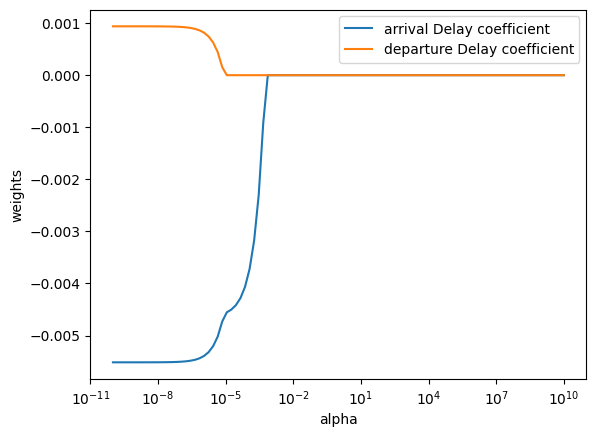

In [50]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, arrDelay_coefficients, label="arrival Delay coefficient")
ax.plot(alphas, depDelay_coefficients, label="departure Delay coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [51]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=1.7886495290574353e-05, max_iter=10000, normalize=True)

In [52]:
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train), 
                                                              lassocv.score(X_test,y_test)))

R^2 on train data is 0.000671414275206228 and on test data is 0.0009865935049659935


In [53]:
pd.Series(lasso.coef_, index=["arr_delay","dep_delay"])

arr_delay   -0.004501
dep_delay   -0.000000
dtype: float64

#### Elastic Net

In [54]:
#Elastic Net
elasticNet = ElasticNet(alpha=1.7886495290574353e-05)
elasticNet.fit(X_train, y_train)


ElasticNet(alpha=1.7886495290574353e-05)

In [55]:
print("R^2 on train data is {} and on test data is {}".format(elasticNet.score(X_train, y_train), 
                                                              elasticNet.score(X_test,y_test)))

R^2 on train data is 0.0006758813133056485 and on test data is 0.0009997523584770462


##### Even though, intuitively, we think that there is a correlation between weather and delays, there really isn’t one. The correlation coefficient between them is very low, and from the graphs we can see that some of them follow a normal distribution, meaning that in extreme cases it might have an impact, but overall the delays just peaks in July and December/January: Holidays. 

**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

In [56]:
filter = weather_df['origin'] == 'JFK'
weather_df.sort_values("origin", inplace = True)
data = weather_df.where(filter).dropna()
X = data.loc[:,['temp','dewp','humid','wind_dir','wind_speed','precip','visib']].values

In [57]:
X_s = preprocessing.StandardScaler().fit_transform(X)
pca4 = decomposition.PCA(n_components=None)
res4 = pca4.fit_transform(X_s)
pca4.explained_variance_ratio_

array([3.78800411e-01, 2.04980335e-01, 1.62167222e-01, 1.05424117e-01,
       8.56196982e-02, 6.26518431e-02, 3.56374562e-04])

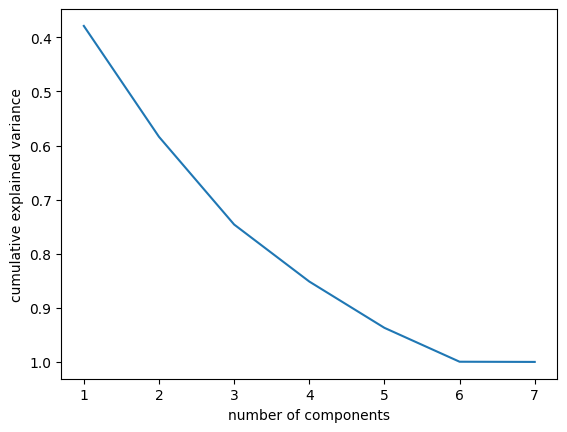

In [58]:
x = list(range(1, 1 + len(pca4.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.gca().invert_yaxis()
plt.show()

**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

In [59]:
data = weather_df.merge(airports_df, left_on='origin',right_on='faa', how='left',)
data = data.fillna(data.median())
y = data.loc[:,['lat']].values
X = data.loc[:,['temp','dewp','humid','wind_dir','wind_speed','precip','visib']].values

In [60]:
#OLS
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
ODS = LinearRegression()
ODS.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train), 
                                                              ODS.score(X_test,y_test)))

R^2 on train data is 0.04185708242561825 and on test data is 0.04821983890153492


In [61]:
#RIDGE 
alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []
y = y.flatten()
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
precip_coefficients = [coef[5] for coef in coefs]
visib_coefficients = [coef[6] for coef in coefs]

print(np.shape(coefs))

(100, 7)


Text(0, 0.5, 'weights')

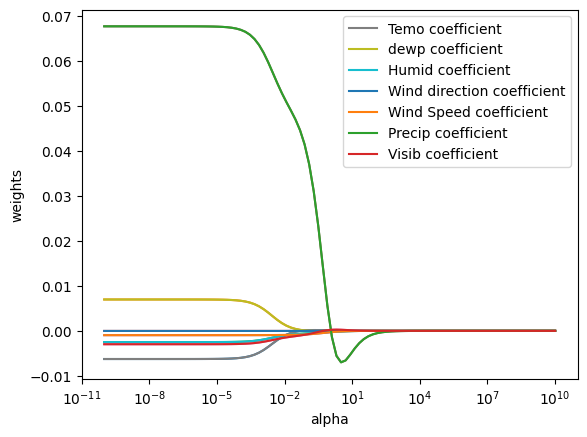

In [62]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.plot(alphas, temp_coefficients, label="Temo coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="Humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="Wind direction coefficient")
ax.plot(alphas, wind_speed_coefficients, label="Wind Speed coefficient")
ax.plot(alphas, precip_coefficients, label="Precip coefficient")
ax.plot(alphas, visib_coefficients, label="Visib coefficient")

ax.set_xscale('log')
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [63]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
for alpha in alphas:
    ridge = Ridge(normalize=True, alpha=alpha)
    ridge.fit(X_train, y_train)
    print("alhpa = {}".format(alpha))
    print("R^2 on train data is {} and on test data is {}".format(ridge.score(X_train, y_train), 
                                                              ridge.score(X_test,y_test)))

alhpa = 1e-10
R^2 on train data is 0.04485800771433379 and on test data is 0.04111044537197628
alhpa = 1.592282793341094e-10
R^2 on train data is 0.044858007714334236 and on test data is 0.04111044544777742
alhpa = 2.5353644939701164e-10
R^2 on train data is 0.04485800771433435 and on test data is 0.041110445568472986
alhpa = 4.03701725859655e-10
R^2 on train data is 0.04485800771433324 and on test data is 0.04111044576065481
alhpa = 6.428073117284319e-10
R^2 on train data is 0.04485800771433357 and on test data is 0.04111044606666214
alhpa = 1.0235310218990269e-09
R^2 on train data is 0.04485800771433246 and on test data is 0.04111044655391427
alhpa = 1.6297508346206469e-09
R^2 on train data is 0.044858007714330794 and on test data is 0.04111044732975322
alhpa = 2.595024211399732e-09
R^2 on train data is 0.044858007714324244 and on test data is 0.041110448565106816
alhpa = 4.132012400115335e-09
R^2 on train data is 0.044858007714309145 and on test data is 0.04111045053213214
alhpa = 6

In [64]:
ridgecv = RidgeCV(alphas = alphas, normalize = True)
ridgecv.fit(X_train, y_train)
#Best alpha
ridgecv.alpha_

1.7886495290574353e-05

In [65]:
ridgecv.coef_

array([-6.78084065e-03,  7.55858115e-03, -2.63418366e-03, -7.45386092e-06,
       -1.00085296e-03,  9.14750125e-02, -2.84219015e-03])

In [66]:
#LASSO
lasso = Lasso(max_iter = 10000, normalize = True,)
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
precip_coefficients = [coef[5] for coef in coefs]
visib_coefficients = [coef[6] for coef in coefs]
print(np.shape(coefs))

(100, 7)


Text(0, 0.5, 'weights')

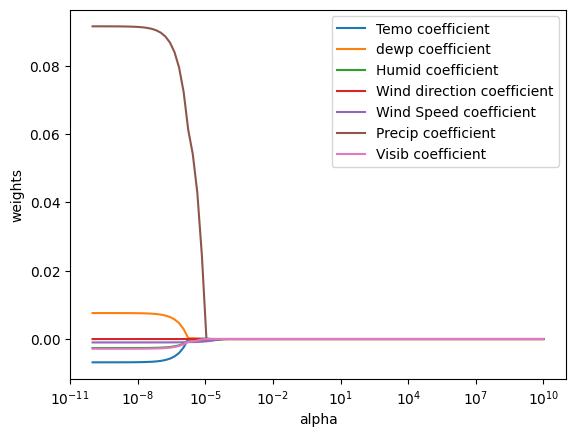

In [67]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, temp_coefficients, label="Temo coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="Humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="Wind direction coefficient")
ax.plot(alphas, wind_speed_coefficients, label="Wind Speed coefficient")
ax.plot(alphas, precip_coefficients, label="Precip coefficient")
ax.plot(alphas, visib_coefficients, label="Visib coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [68]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True,)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=1.0476157527896662e-08, max_iter=10000, normalize=True)

In [69]:
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train), 
                                                              lassocv.score(X_test,y_test)))

R^2 on train data is 0.044857604604849666 and on test data is 0.04113010133214112


In [70]:
pd.Series(lasso.coef_, index=['temp','dewp','humid','wind_dir','wind_speed','precip','visib'])
#Three most important features are  precip,dewp and temp

temp         -0.006784
dewp          0.007562
humid        -0.002635
wind_dir     -0.000007
wind_speed   -0.001001
precip        0.091420
visib        -0.002842
dtype: float64

In [71]:
#REDO ANALYSIS
data = weather_df.merge(airports_df, left_on='origin',right_on='faa', how='left',)
data = data.fillna(data.median())
y = data.loc[:,['lat']].values
X = data.loc[:,['temp','dewp','precip']].values
#OLS
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
ODS = LinearRegression()
ODS.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train), 
                                                              ODS.score(X_test,y_test)))
#OLS IS HALF OF THE PREVIOUS DATA

R^2 on train data is 0.019763118328946727 and on test data is 0.017520113902584455


In [72]:
#RIDGE 
alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []
y = y.flatten()
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
precip_coefficients = [coef[2] for coef in coefs]

print(np.shape(coefs))

(100, 3)


In [73]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
for alpha in alphas[:10]:
    ridge = Ridge(normalize=True, alpha=alpha)
    ridge.fit(X_train, y_train)
    print("alhpa = {}".format(alpha))
    print("R^2 on train data is {} and on test data is {}".format(ridge.score(X_train, y_train), 
                                                              ridge.score(X_test,y_test)))

alhpa = 1e-10
R^2 on train data is 0.01918304924156433 and on test data is 0.01957602938488434
alhpa = 1.592282793341094e-10
R^2 on train data is 0.019183049241562777 and on test data is 0.01957602938432168
alhpa = 2.5353644939701164e-10
R^2 on train data is 0.019183049241562777 and on test data is 0.019576029383428284
alhpa = 4.03701725859655e-10
R^2 on train data is 0.01918304924156433 and on test data is 0.0195760293820062
alhpa = 6.428073117284319e-10
R^2 on train data is 0.019183049241561667 and on test data is 0.019576029379739013
alhpa = 1.0235310218990269e-09
R^2 on train data is 0.01918304924156322 and on test data is 0.019576029376131232
alhpa = 1.6297508346206469e-09
R^2 on train data is 0.01918304924156322 and on test data is 0.01957602937038605
alhpa = 2.595024211399732e-09
R^2 on train data is 0.019183049241562222 and on test data is 0.019576029361235592
alhpa = 4.132012400115335e-09
R^2 on train data is 0.019183049241561334 and on test data is 0.019576029346668355
alhpa 

In [74]:
ridgecv = RidgeCV(alphas = alphas, normalize = True)
ridgecv.fit(X_train, y_train)
#Best alpha
ridgecv.alpha_,ridgecv.coef_

(0.0004641588833612782, array([ 0.00177448, -0.00162463,  0.03154089]))

In [75]:
#LASSO
lasso = Lasso(max_iter = 10000, normalize = True,)
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
precip_coefficients = [coef[2] for coef in coefs]
print(np.shape(coefs))

(100, 3)


In [76]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True,)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=1.6297508346206469e-09, max_iter=10000, normalize=True)

In [77]:
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train), 
                                                              lassocv.score(X_test,y_test)))

R^2 on train data is 0.01918304902185819 and on test data is 0.01957597151941015


In [78]:
pd.Series(lasso.coef_, index=['temp','dewp','precip'])

temp      0.001783
dewp     -0.001632
precip    0.031948
dtype: float64

**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

In [7]:


average_delays_by_airport = flights_df.dropna().groupby(['dest'])['dep_delay'].mean()
full_pd = pd.merge(airports_df, average_delays_by_airport, left_on='faa', right_on='dest')
scaled_features = full_pd.copy()
col_names = ['dep_delay']
features = scaled_features[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features

fig = px.scatter_geo(scaled_features, lat='lat', lon='lon',
                     hover_name="name", size="dep_delay", 
                     scope='usa')
fig.show()

 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

If the training error and validation error are almost equal and fairly high, then it is likely that the model is suffering from high bias, which means that it is underfitting the data. In this case, you should try reducing the regularization hyperparameter, which will allow the model to fit the training data more closely and potentially reduce the bias.

Ridge regression is a type of regularized linear regression that uses L2 regularization. This means that it adds a penalty term to the cost function that is proportional to the square of the magnitude of the coefficients. This penalty term forces the coefficients to be smaller, which can help prevent overfitting. Therefore, you would want to use Ridge regression instead of plain Linear regression if you are concerned about overfitting.

Lasso regression is another type of regularized linear regression that uses L1 regularization. This means that it adds a penalty term to the cost function that is proportional to the absolute value of the coefficients. This penalty term forces the coefficients to be zero if they are not important for the model, which can help reduce the number of features and prevent overfitting. Therefore, you would want to use Lasso regression instead of Ridge regression if you want to perform feature selection.

Elastic net regression is a combination of Ridge and Lasso regression. It uses both L1 and L2 regularization, which can help balance the effects of the two types of regularization. Therefore, you would want to use Elastic net regression instead of Lasso regression if you want to take advantage of the benefits of both L1 and L2 regularization.

## 3. Clustering of Handwritten Digits - Ion

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [88]:

mnist = loadmat('MNIST_DATA/mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
import numpy as np
print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(np.unique(mnist_label)))

Number of datapoints: 70000

Number of features: 784

List of labels: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]



There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

Value of datapoint no. 4:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  46 105 254 254 254 254 255 239  41
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  37
 118 222 254 253 253 253 253 253 253 211  54   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  14 200 253 253 254 253 253 253 253 253
 253 253 116   0   0   0   0   0   0   0   0   0   0   0   0   0  16 160
 236 253 253 253 254 253 

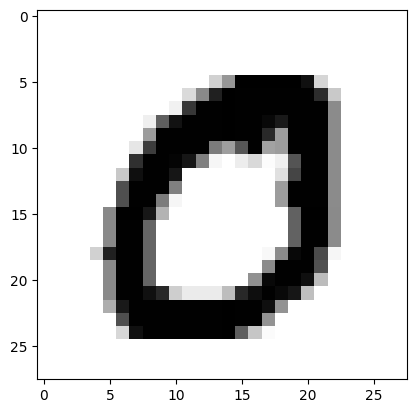

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 4
print("Value of datapoint no. {}:\n{}\n".format(index,mnist_data[index]))
print("As image:\n")
plt.imshow(mnist_data[index].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

**(a)** Perform k-means clustering with k=10 on this dataset.

In [90]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mnist_data)
X = scaler.transform(mnist_data)
# X = mnist_data
k=10 # use a multiple of 5
kmeansclus = KMeans(n_clusters=k,n_init =10,random_state=69).fit(X)

**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

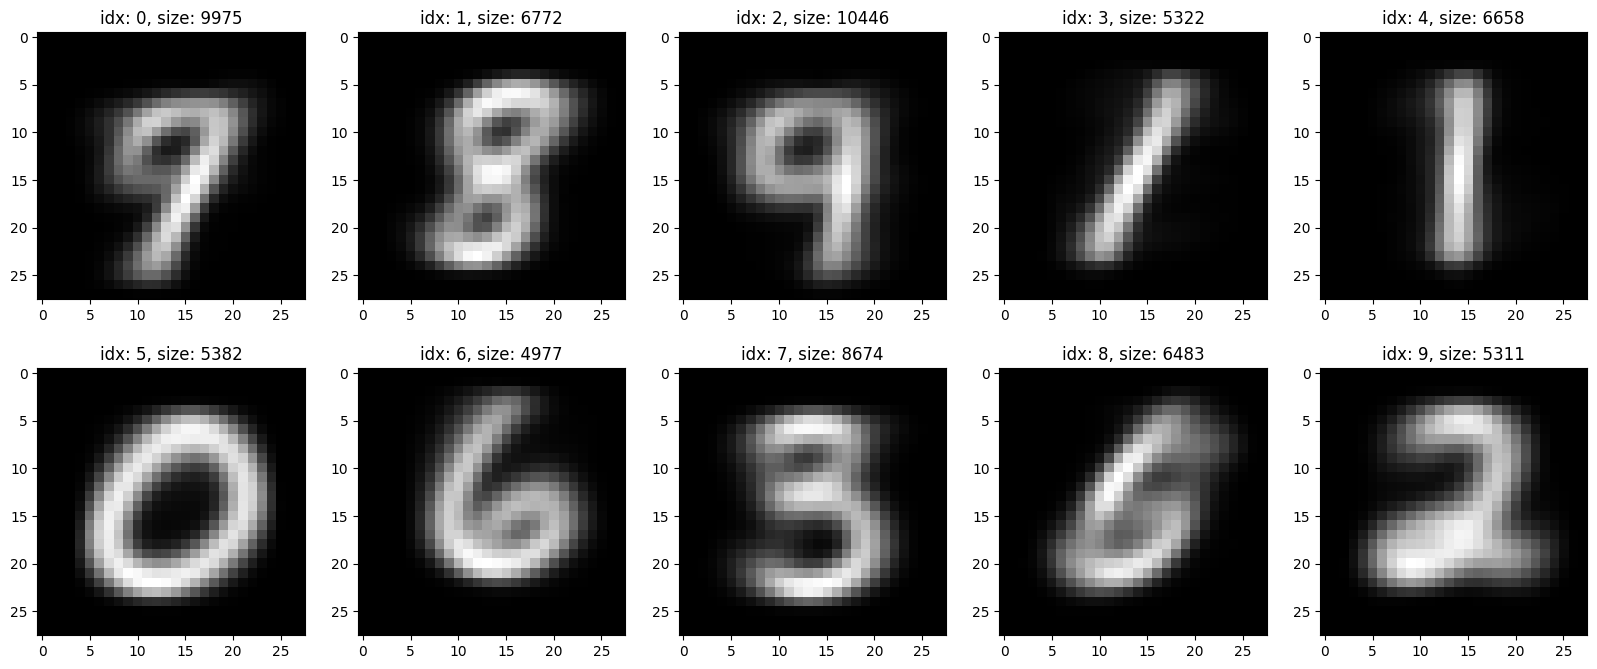

In [91]:
rows=int(k/5)
fig,axes = plt.subplots(rows,5,figsize=(20,4*rows))
for ax,cc,i in zip (axes.ravel(),kmeansclus.cluster_centers_,np.arange(axes.ravel().size)):
    ax.set_title("idx: {}, size: {}".format(i,len(np.where(kmeansclus.labels_==i)[0])))
    ax.imshow(cc.reshape((28,28)),cmap='gray')
plt.show()  

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

In [92]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(mnist_label,kmeansclus.labels_)

0.36520869228069386

2
7.0


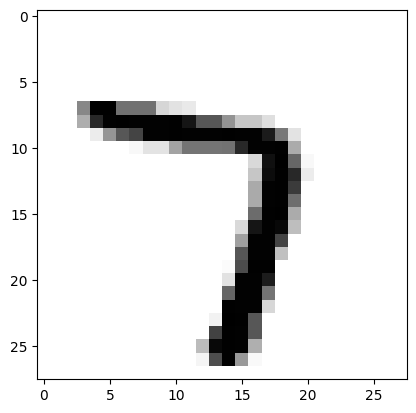

In [93]:
print(kmeansclus.labels_[45500])
print(mnist_label[45500])
plt.imshow(mnist_data[45500].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

In [94]:
import sklearn
small_mnist_data,small_mnist_label = sklearn.utils.resample(mnist_data,mnist_label,n_samples=200,replace='false')

In [95]:
#agglomerative clustering
from sklearn.cluster import AgglomerativeClustering 

agg = AgglomerativeClustering(n_clusters=10,linkage='ward')
agg.fit(small_mnist_data)
labels = agg.labels_
adjusted_rand_score(small_mnist_label,labels)

0.2770170974224632

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

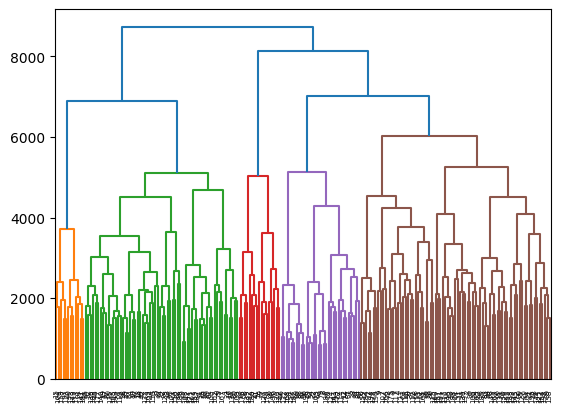

In [96]:
from scipy.cluster.hierarchy import dendrogram,ward,single,average, complete, fcluster

linkage_array= ward(small_mnist_data)

dendrogram(linkage_array)
plt.show()

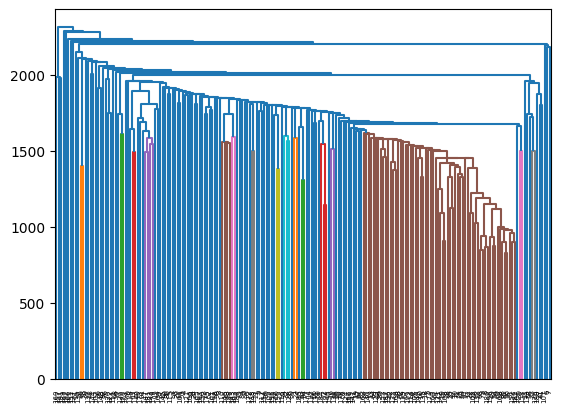

In [97]:
linkage_array= single(small_mnist_data)

dendrogram(linkage_array)
plt.show()

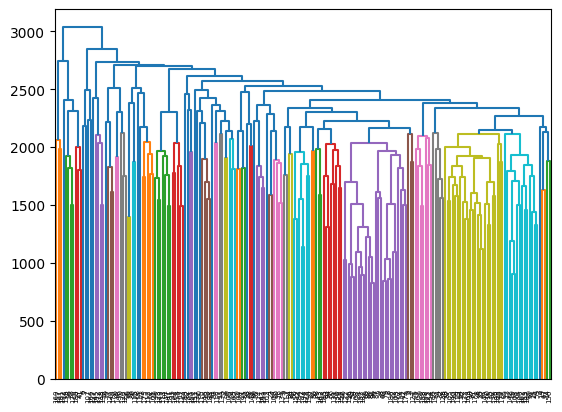

In [98]:
linkage_array= average(small_mnist_data)

dendrogram(linkage_array)
plt.show()

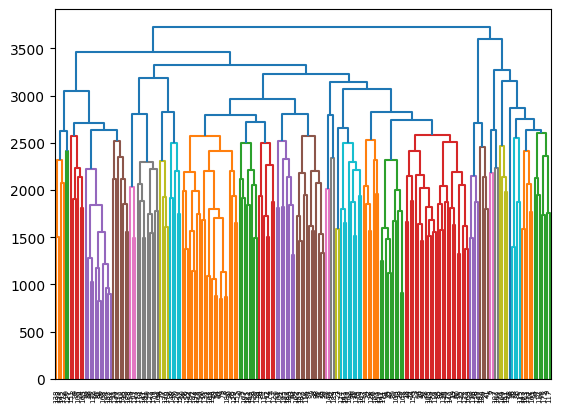

In [99]:
linkage_array= complete(small_mnist_data)

dendrogram(linkage_array)
plt.show()

In [100]:
### FCLUSTER NOT IMPLEMENTED

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

In [ ]:
# # ####NOT IMPLEMENTED

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

In [ ]:
###NOT IMPLEMENTED

## 4. The Local Elections - Andrei, Daniel

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

In [101]:
answers = np.load('Elections Data/X_Horsens.npy')
parties = np.load('Elections Data/Y_Horsens.npy')

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

##### Members of the same party tend to give similar answers, so classifing them would in theory be easy as they can be fit to the party's overall tendency

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

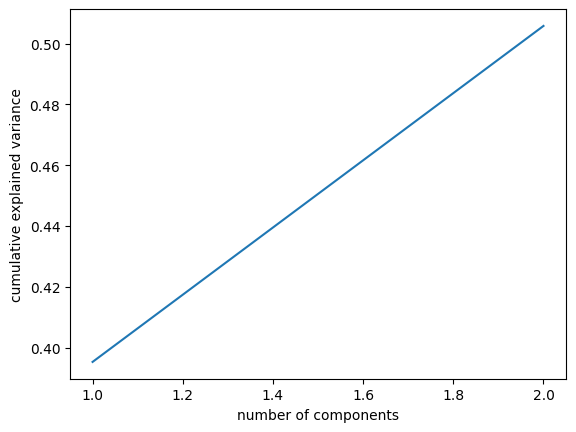

In [102]:
X_s = preprocessing.StandardScaler().fit_transform(answers)
pca4 = decomposition.PCA(n_components=2)
res4 = pca4.fit_transform(X_s)
pca4.explained_variance_ratio_

x = list(range(1, 1 + len(pca4.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.gca().invert_yaxis()
plt.show()

Text(0, 0.5, 'Second principal component')

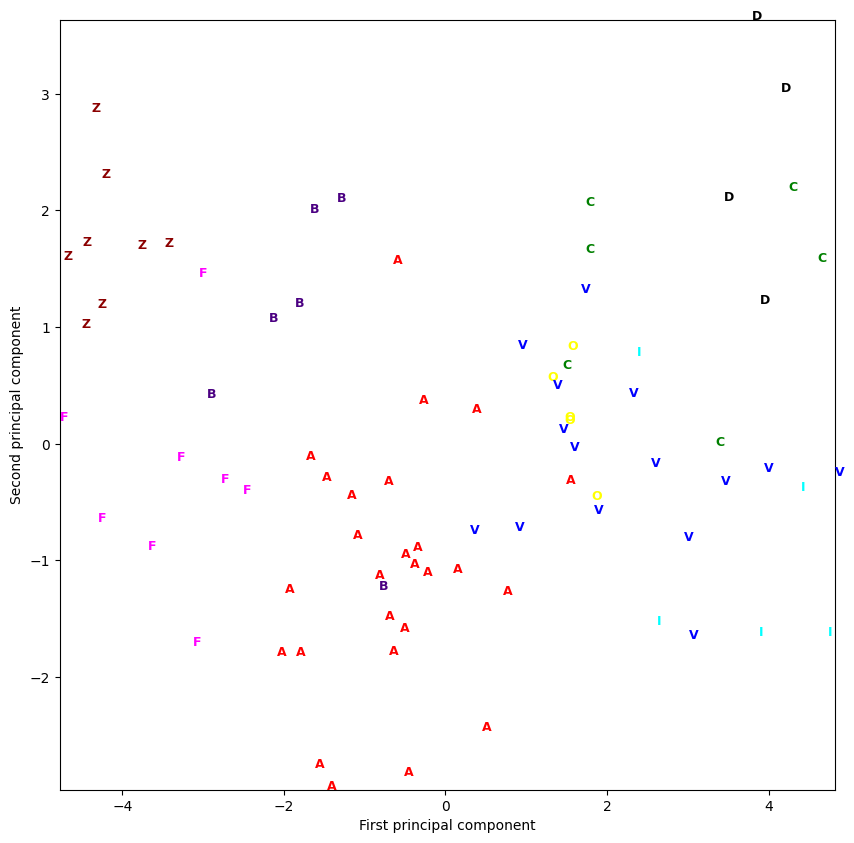

In [103]:
colors = {'A':"RED", 'B':"INDIGO",'C': "GREEN", 'D':"Black", 'F':"Fuchsia",
          'I':"Cyan", 'O':"Yellow", 'V':"Blue",'Z': "#8B0000"}
plt.figure(figsize=(10, 10))
plt.xlim(res4[:, 0].min(), res4[:, 0].max())
plt.ylim(res4[:, 1].min(), res4[:, 1].max())
for i in range(len(parties)):
    # actually plot the digits as text instead of using scatter
    plt.text(res4[i, 0], res4[i, 1], str(parties[i]),
             color = colors[parties[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

Text(0, 0.5, 'Principal components')

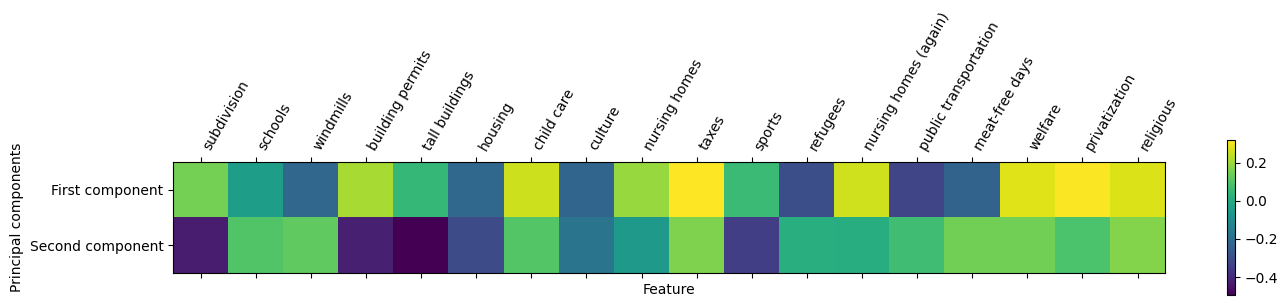

In [104]:
question_names = ['subdivision', 'schools', 'windmills', 'building permits', 'tall buildings', 'housing',
                  'child care', 'culture', 'nursing homes', 'taxes', 'sports', 'refugees', 'nursing homes (again)',
                  'public transportation', 'meat-free days', 'welfare', 'privatization', 'religious']

plt.matshow(pca4.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(question_names)),
           question_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

##### The policital parties can even at this point be separated, as we can observe in the plot of the first 2 PCA components. Obviously, they do overlap, meaning that some party memebers answers might be categoriesed as a diferent party's tendencies.

##### Can the typical distinction of "left-wing" and "right-wing" be discerned?
##### Yes, funny enough, their position on the plot represends their party's orientation (left, vs right) -> left parties are distrubited on the lower part of the first PCA, and right ones on the upper part of it.

The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

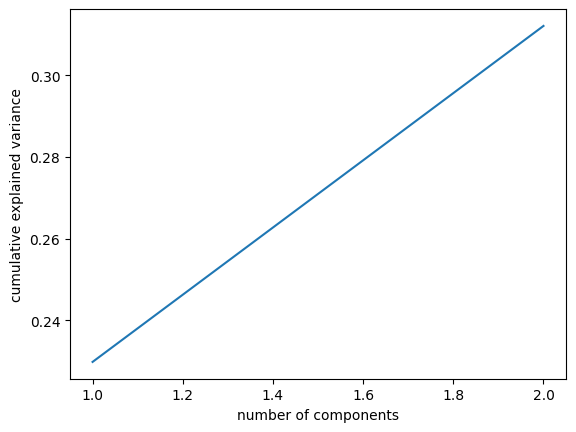

Text(0, 0.5, 'Principal components')

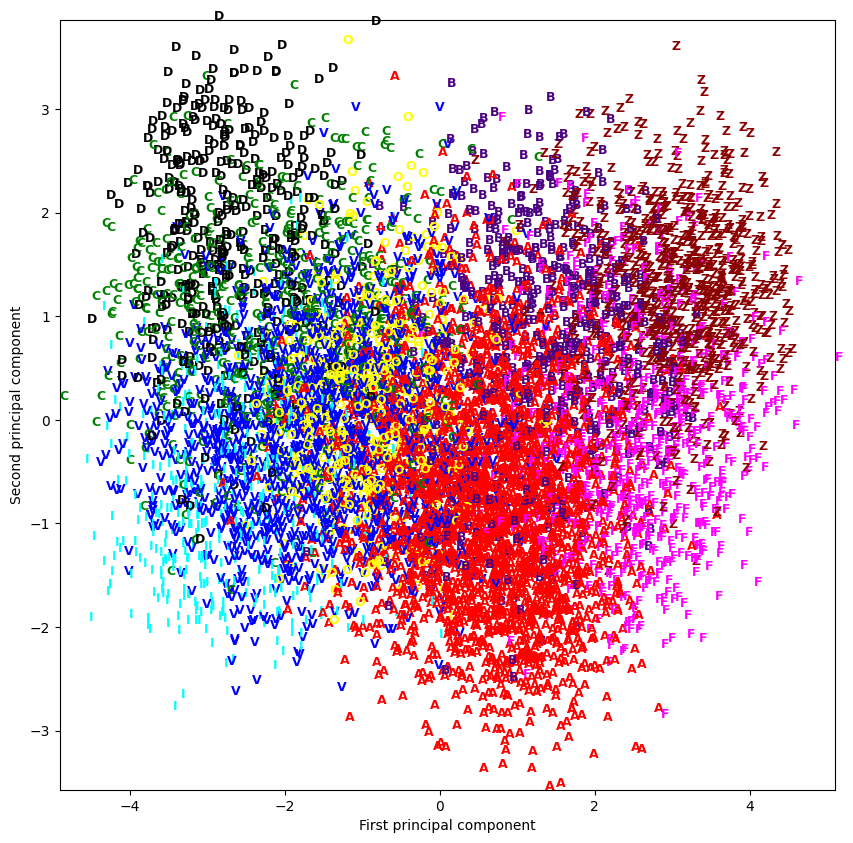

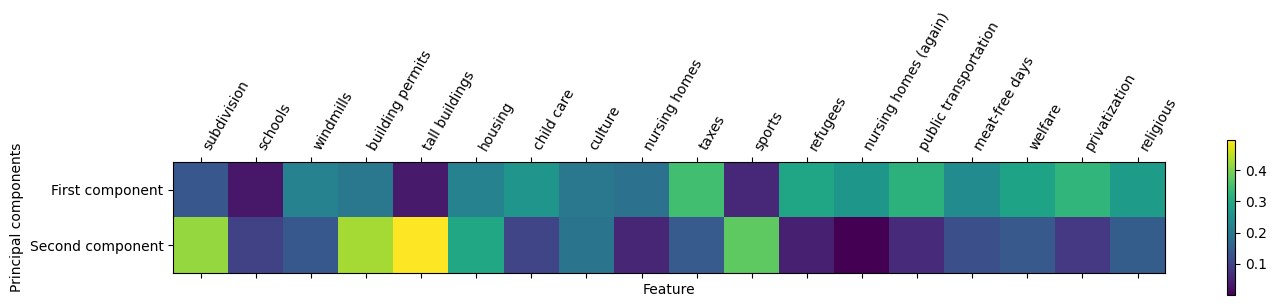

In [105]:
answersDataborg = np.load('Elections Data/X_Databorg.npy')
partiesDataborg = np.load('Elections Data/Y_Databorg.npy')


X_s = preprocessing.StandardScaler().fit_transform(answersDataborg)
pca4 = decomposition.PCA(n_components=2)
res4 = pca4.fit_transform(X_s)
pca4.explained_variance_ratio_

x = list(range(1, 1 + len(pca4.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

colors = {'A':"RED", 'B':"INDIGO",'C': "GREEN", 'D':"Black", 'F':"Fuchsia",
          'I':"Cyan", 'O':"Yellow", 'V':"Blue",'Z': "#8B0000"}
plt.figure(figsize=(10, 10))
plt.xlim(res4[:, 0].min(), res4[:, 0].max())
plt.ylim(res4[:, 1].min(), res4[:, 1].max())
for i in range(len(partiesDataborg)):
    # actually plot the digits as text instead of using scatter
    plt.text(res4[i, 0], res4[i, 1], str(partiesDataborg[i]),
             color = colors[partiesDataborg[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

question_names = ['subdivision', 'schools', 'windmills', 'building permits', 'tall buildings', 'housing',
                  'child care', 'culture', 'nursing homes', 'taxes', 'sports', 'refugees', 'nursing homes (again)',
                  'public transportation', 'meat-free days', 'welfare', 'privatization', 'religious']

plt.matshow(np.abs(pca4.components_), cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(question_names)),
           question_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")



###### Comparing the data to Horesns
###### The PCA Analysis of Databorg seems pretty familiar, given that the parties can be separated visually into, as they tend to group themselves, but a key diference is that the left and right-wing parties now changed position between them on the axis of the first PCA. Right wing parties now sit on the lower end of the first PCA and vice-versa..

###### Another interesting factor is that now the most important features for the first PCA changed to regurees and public transportatoin

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

In [106]:
# anwers are the features (X)
# parties are the labels (y)

X_train, X_test, y_train, y_test = train_test_split(answersDataborg, partiesDataborg, test_size=0.2, random_state=69, stratify=partiesDataborg)

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

##### We assume that Naive Bayes is not the best approach in this case, as it by default implies that features are independent of eachother. Even though it is hard to find a case in which the features are not independent, this case is completely off, because answers to some questions ar most of the time much more denedepnt between them in the case of controversial political issues

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

In [107]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

NB_y_pred = model.fit(X_train, y_train).predict(X_test) 

print("Model accuracy on the test data: {}".format(model.score(X_test,y_test)))
print("Model accuracy on the train data: {}".format(model.score(X_train,y_train)))

Model accuracy on the test data: 0.708433734939759
Model accuracy on the train data: 0.7206325301204819


Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

In [108]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=29)
model.fit(X_train, y_train)

kNN_y_pred = model.fit(X_train, y_train).predict(X_test) 

print("Model accuracy on the test data: {}".format(model.score(X_test,y_test)))
print("Model accuracy on the train data: {}".format(model.score(X_train,y_train)))

Model accuracy on the test data: 0.8162650602409639
Model accuracy on the train data: 0.8341867469879518


##### The time that it takes is longer than the NB, but the performance is way better, 0.1 diference in accuracy

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

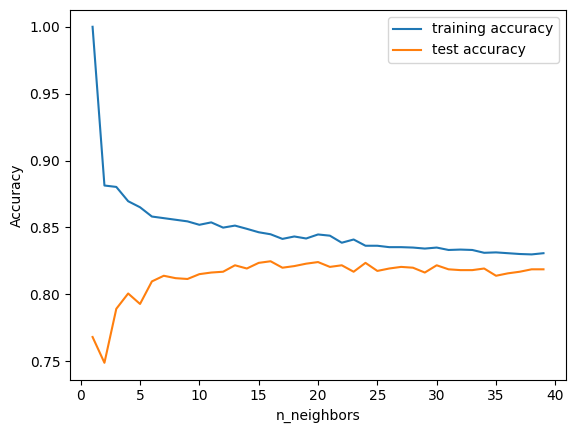

In [110]:
training_accuracy = []
test_accuracy = []

ks = range(1, 40)

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(ks, training_accuracy, label="training accuracy")
plt.plot(ks, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

##### It seems like 29 is the perfect number of neighours, since that gives lowest difference between training and test, while still keeping a pretty good accuraccy all around, without over or underfitting

We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

##### Minimum depth of an appropriate decision tree in this case is 4, because it is the first number greater than log2(9) - 9 being the number of leaves

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

In [111]:
# remember 
# conda install -c anaconda python-graphviz
# and
# conda install -c anaconda pydotplus

%matplotlib inline 
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
import pydotplus

clf = DecisionTreeClassifier(max_depth=9)
clf.fit(X_train, y_train)

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
dot_data = export_graphviz(clf, out_file=None,
                           class_names=np.unique(partiesDataborg),
                           feature_names=question_names, 
                           filled=True)

graph = graphviz.Source(dot_data)


In [ ]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"15,15!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

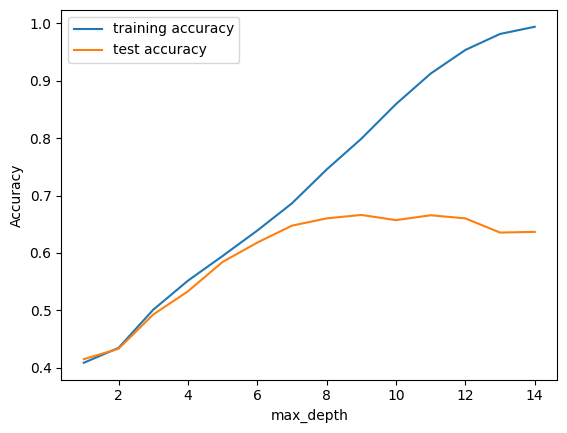

In [112]:
training_accuracy = []
test_accuracy = []

ks = range(1, 15)

for k in ks:
    clf = DecisionTreeClassifier(max_depth=k)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(ks, training_accuracy, label="training accuracy")
plt.plot(ks, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()

##### 5 seems to be the best depth to train the decision tree on, anything more then that tends to oferfit. It performs worse then knn, with an accuracy around 0.6. We will keep the max_depth at 5 for now.

In [115]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DTC_y_pred = clf.fit(X_train, y_train).predict(X_test) 

print("Train score: {}".format(clf.score(X_train, y_train)))
print("Test score: {}".format(clf.score(X_test, y_test)))

Train score: 0.5947289156626506
Test score: 0.5843373493975904


__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

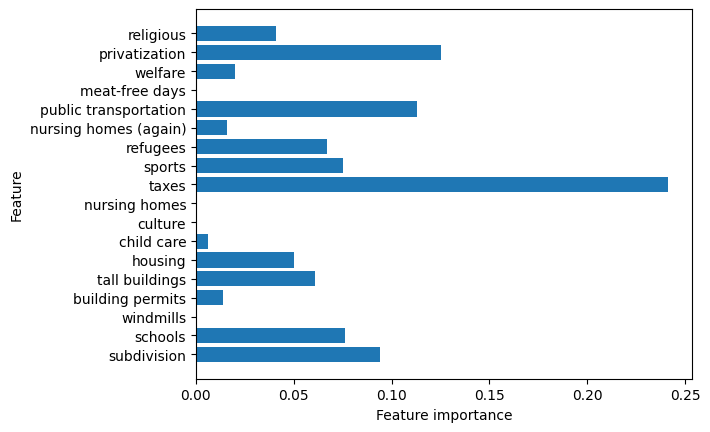

In [116]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

def plot_feature_importances_cancer(model):
    n_features = answersDataborg.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), question_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_cancer(clf)


#### The most importeant features seem to be the same, as they tend to divide opinions the most and it makes sense that they are cmoparable to the PCA analysis

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

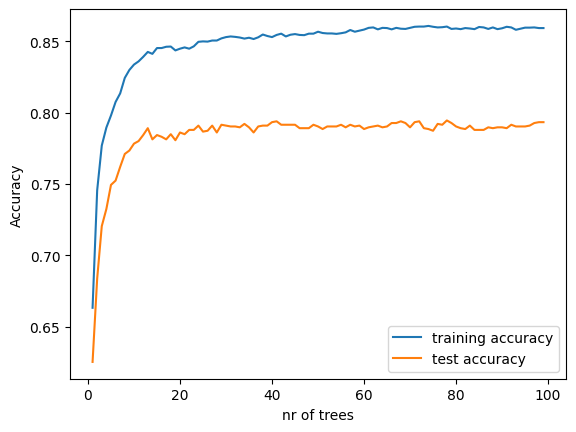

In [117]:
from sklearn.ensemble import RandomForestClassifier

training_accuracy = []
test_accuracy = []

ks = range(1, 100)

for k in ks:
    forest = RandomForestClassifier(n_estimators=k, min_samples_leaf=9, min_samples_split=10, random_state=69)
    forest.fit(X_train, y_train)
     # record training set accuracy
    training_accuracy.append(forest.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest.score(X_test, y_test))
    
    
plt.plot(ks, training_accuracy, label="training accuracy")
plt.plot(ks, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("nr of trees")
plt.legend()

##### Seems like 5 is an appropriate number of trees in the forest to have a similar and high accuracy between train and test data:

In [118]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=5, min_samples_leaf=9, min_samples_split=10, random_state=69)
forest.fit(X_train, y_train)
 # record training set accuracy
train_score = forest.score(X_train, y_train)
# record generalization accuracy
test_score = forest.score(X_test, y_test)

RFDT_y_pred = forest.fit(X_train, y_train).predict(X_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Train score: 0.7980421686746988
Test score: 0.7493975903614458


__(n)__ Extract the most important features. Comment and compare with previously obtained results.

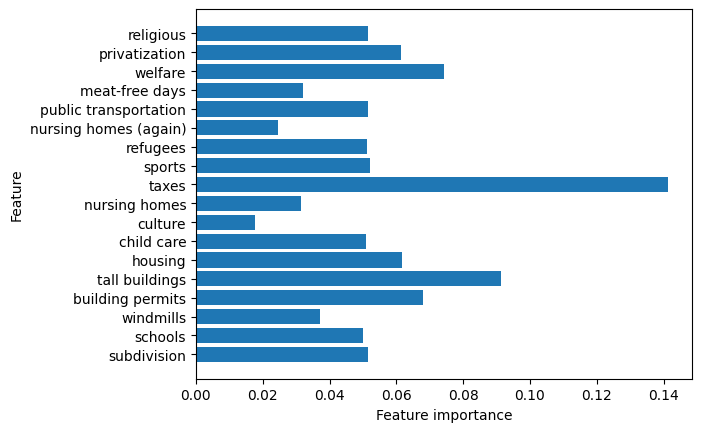

In [119]:
plot_feature_importances_cancer(forest)

##### the most important features seem to be the same, although some other features gain more importance

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

#### Naive-Bayes

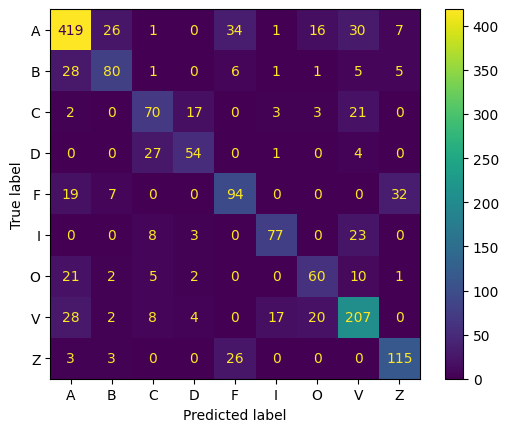

Accuracy measures how often the model is correct: 0.708433734939759
Precision measures percentage of true positive: 0.7102592485325918
Sensitivity is good at understanding how well the model predicts something is positive: 0.708433734939759
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.7088466311170895


In [120]:
actual = NB_y_pred
predicted = y_test
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["A","B","C","D","F","I","O","V","Z"])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))



#### KNN

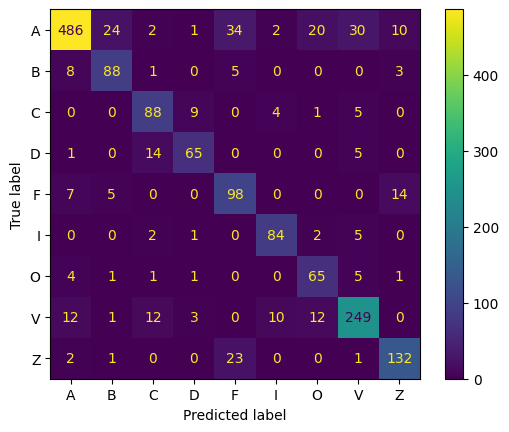

Accuracy measures how often the model is correct: 0.8162650602409639
Precision measures percentage of true positive: 0.8305210457213468
Sensitivity is good at understanding how well the model predicts something is positive: 0.8162650602409639
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.819573190311407


In [121]:
actual = kNN_y_pred
predicted = y_test
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["A","B","C","D","F","I","O","V","Z"])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))


#### Decision Trees

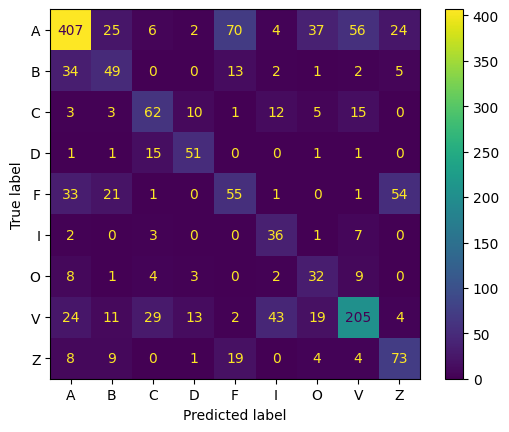

Accuracy measures how often the model is correct: 0.5843373493975904
Precision measures percentage of true positive: 0.6179059314179798
Sensitivity is good at understanding how well the model predicts something is positive: 0.5843373493975904
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.5937218303061282


In [122]:
actual = DTC_y_pred
predicted = y_test
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["A","B","C","D","F","I","O","V","Z"])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))


#### Random Forest

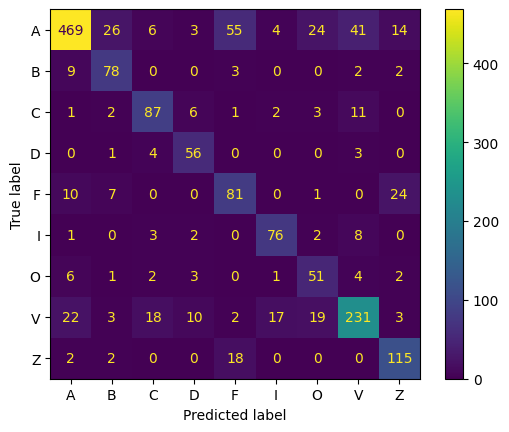

Accuracy measures how often the model is correct: 0.7493975903614458
Precision measures percentage of true positive: 0.7731729610750695
Sensitivity is good at understanding how well the model predicts something is positive: 0.7493975903614458
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.7545216118277974


In [123]:
actual = RFDT_y_pred
predicted = y_test
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["A","B","C","D","F","I","O","V","Z"])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))


##### The results are quite similar to our expectations. Political affiliation would be very easy to predict in a bi-partial system, but given that we have 9 parties, with some of them having the same values is somewhat of an interesting thing. They still tend to be more RED or GREEN in the Danish system, so guessing partial affiliation sounds like an easy task, but getting precise results based on some questions makes us think that our accuracies of around 70% tend to reflect the reality.

##### kNN seems to give the best accuracy, followed by random tree forsts, which we did not really expect, given that decision trees are so far behind.

## 5. Sentiment Analysis - Ion, Andrei

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [124]:
reviews = pd.read_csv('Sentiment Analysis/reviews.txt', header=None)
labels = pd.read_csv('Sentiment Analysis/labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(reviews.head)
print(labels.head)
Y=to_categorical(Y, 2)

<bound method NDFrame.head of                                                        0
0      bromwell high is a cartoon comedy . it ran at ...
1      story of a man who has unnatural feelings for ...
2      homelessness  or houselessness as george carli...
3      airport    starts as a brand new luxury    pla...
4      brilliant over  acting by lesley ann warren . ...
...                                                  ...
24995  i saw  descent  last night at the stockholm fi...
24996  a christmas together actually came before my t...
24997  some films that you pick up for a pound turn o...
24998  working  class romantic drama from director ma...
24999  this is one of the dumbest films  i  ve ever s...

[25000 rows x 1 columns]>
<bound method NDFrame.head of               0
0      positive
1      negative
2      positive
3      negative
4      positive
...         ...
24995  negative
24996  positive
24997  negative
24998  positive
24999  negative

[25000 rows x 1 columns]>


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

In [125]:
X_train, X_test, y_train, y_test = train_test_split(reviews, Y, test_size=0.2, random_state=69, stratify = Y)

**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [126]:
y_train = np.array(y_train)
y_test = np.array(y_test)

stopwords = stopwords.words("english")
stopwords.extend(['br', 'p'])

vect = CountVectorizer(max_features=10000, stop_words =stopwords).fit(X_train[0])
X_train = vect.transform(X_train[0]).toarray()
X_test = vect.transform(X_test[0]).toarray()

**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

##### Top 1000 words:

In [127]:
print(vect.get_feature_names_out())

['aaron' 'abandon' 'abandoned' ... 'zoom' 'zorro' 'zu']


###### A word is represented as a number of appearances in a sentance, corresponding with its index from the bag of words

###### This is how a review is represented -> an array of 10000 elements (the entire bag of words)  - index corresponds to the bag of words and value repesents appearece in the sentance:

In [128]:
print(X_train[0])

[0 0 0 ... 0 0 0]


###### The first word that's found in the sentance is:

In [129]:
i = np.where(X_train[0] > 1)
print(vect.get_feature_names_out()[i[0][0]])

film


**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [130]:
seed(69)
tf.random.set_seed(69)
input_size = X_train[0].shape[0]
num_classes = 2 #positive or negative

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10) #early stoppage when it tends to overfit
model = Sequential() #initialize a neural network
#add a hidden layer. L1 regularizer (Lasso - deletes the features if their importance is low)
model.add(Dense(units = 10, activation = 'tanh', input_dim = input_size, kernel_regularizer = regularizers.l1(0.003)))
model.add(Dense(units = num_classes, activation = 'softmax')) #add the output layer

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])#sgd = optimizers.SGD(learning_rate = 0.1))
history = model.fit(X_train, y_train, epochs = 200, batch_size = 100, verbose = 1, validation_split = 0.2, callbacks = [callback])

Epoch 1/200
160/160 [==============================] - 2s 8ms/step - loss: 0.8703 - accuracy: 0.8137 - val_loss: 0.6889 - val_accuracy: 0.8350
Epoch 2/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6806 - accuracy: 0.8359 - val_loss: 0.6652 - val_accuracy: 0.8450
Epoch 3/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6705 - accuracy: 0.8410 - val_loss: 0.6929 - val_accuracy: 0.8322
Epoch 4/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6616 - accuracy: 0.8472 - val_loss: 0.6454 - val_accuracy: 0.8497
Epoch 5/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6544 - accuracy: 0.8476 - val_loss: 0.6454 - val_accuracy: 0.8575
Epoch 6/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6505 - accuracy: 0.8518 - val_loss: 0.6399 - val_accuracy: 0.8533
Epoch 7/200
160/160 [==============================] - 1s 7ms/step - loss: 0.6471 - accuracy: 0.8549 - val_loss: 0.6307 - val_accuracy: 0.8593

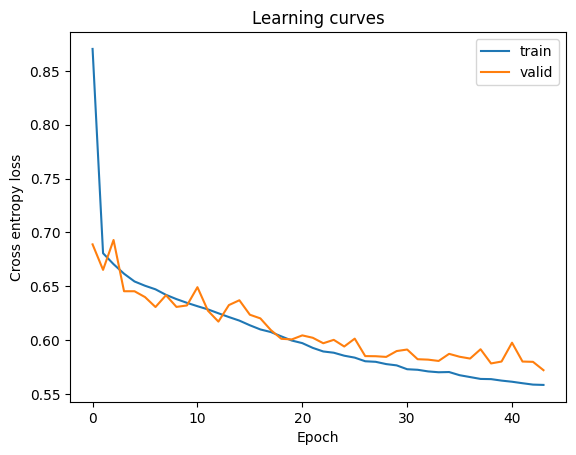

In [131]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

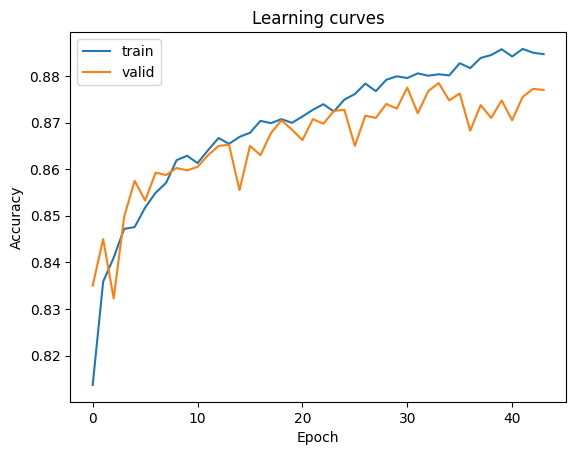

In [132]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.show()

**(e)** Test your sentiment-classifier on the test set.

In [133]:
print("Loss + accuracy on train data: {}".format(model.evaluate(X_train, y_train)))
print("Loss + accuracy on test data: {}".format(model.evaluate(X_test, y_test)))

625/625 [==============================] - 1s 2ms/step - loss: 0.5277 - accuracy: 0.9027
Loss + accuracy on train data: [0.5276798009872437, 0.9027000069618225]
157/157 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.8694
Loss + accuracy on test data: [0.599189043045044, 0.8694000244140625]


**(h)** Use the classifier to classify a few sentences you write yourselves. 

In [134]:
# first 3 reviews are taken from IMDB to see if the score matches the sentiment

# ----- good reviews ------
review1 = 'It is now past 1 PM and I just finished watching Francis Ford Coppola\'s "The Godfather". I should probably go to bed. It\'s late and tomorrow I have to wake up a bit early. But not early enough to postpone writing these lines. Now that I have seen it three times, the opportunity of sharing my thoughts and refreshed insights are too much of a good offer to sit on. So, bear with me. This film works so well because it takes place in an underworld in which we are so embedded that we do not even observe it. Coppola puts us straight in the smack-dab center of what is, admittedly, a society made by criminals for criminals. It is also the reason why it\'s so welcoming. We are surrounded by its inhabitants--cold-blooded murderers, men who see crime like a 9 to 5 job masquerading as honorable men. And I do mean men. From the outside, we would only witness the horrifying, disturbing manifestations of their well-thought out actions. But it goes even deeper than that. It all revolves around the Corleone family led by Don Vito Corleone (Marlon Brando). He is the most honest of these men, sitting right on the edge. But for people like him, who do not fully embrace this world, it\'s not easy. He avoids conflict until it is absolutely necessary. He is a man defined by moral principles. There is a scene at the beginning, in which, during his daughter\'s wedding day, one of his associates, Luca Brasi (Lenny Montana) practices his speech that he is going to give to the Don when he meets him. The scene with these two is funny and almost adorable. I could not help but sympathize both of them only to realize that I am feeling warmth for two mobsters. Not to even mention that Lenny Montana was an actual mob hit-man and that he was actually nervous as he said that line. The more I watched the more I realized just how incredibly complex and ruthless this society is and how it has the power to corrupt anyone to come in contact with it. The best example is Corleone\'s youngest son, Michael (Al Pacino). He returns home for his sister\'s wedding as a war hero dressed the part with his long-time girlfriend, Kay Adams (Diane Keaton). At first, he avoids this underworld, but necessity, first-hand exposure and just its sheer devilish appealing nature draws him in. As we get further in the film, the change is shocking and every outsider who ever got close to him is tainted in one way or another. If they survive it, they are drawn in as well as we are as viewers. Inside, Coppola exposes the family to us fully, with a bold personal approach and we witness every discussion, every methodically calculated choice. Crime is done simply because it is the nature of their business, and we are put on a chair alongside them, so we easily relate. For us, they are the good guys, the rival families are the bad guys. This is the greatest feat this film managed to pull off--set apart good guys and bad guys in a world filled with bad guys. This is a film of unmatched subtlety. No other movie sustains itself as good. No other film is done with such precision, attention and completeness. There are many layers which I probably missed and maybe will never notice. But I felt them. What director Francis Ford Coppola and his partner in crime (poor choice of words, sorry) Mario Puzo did is nothing short of a timeless piece of reference cinema whose influence is not based on reinventing the wheel, but rather perfecting it to the absolute maximum. Most masterpieces are remembered for their historical contributions. "Citizen Kane" brought the biggest step-up to the art form, the same things did "Gone With the Wind" or "2001: A Space Odyssey". "The Godfather" is one of the few films that will be remembered simply because they are that good and I cannot possibly imagine a greater achievement.'
review2 = 'Nice story, didn\'t feel like a movie'
review3 = 'This film was probably a fascinating piece of sci-fi writing, but as a movie it was a pretty weak effort. From the cinematography to the acting - this was a non-budget sci-fi channel original movie. Sub-career actors giving hammy performances - often skating the line of annoying. I have to admit that the basic story here is very interesting and thought provoking. I cant say it was perfectly written, but this is science fiction. I think this would work good as a play. Id also like to see this re-done with a better cast and director. In the end though - there was nothing here that gave me chills or touched me in some special way or gave me any sort of epiphany like it seems to have done for so many others... At best it held my attention until the end. Its very much average and mediocre - it will end up being the sort of thing people will reference in speculative conversations with their friends to help them feel smarter. It will end up being shown to high school and college students by that hip and cool teacher. Its very accessible and gently challenges religion, so its perfect for that. Ive definitely seen better science fiction movies - with or without action or special effects.'
review4 = 'Such a fantastic movie'

# ----- bad reviews ------
review5 = 'This was a freaking disaster, nothing good came out of it'
review6 = 'I didn\'t like this movie, the could have done a better job'
review7 = 'Can we even call this a movie?'
review8 = 'How did anyone last enough in the cinema?'

# ----- mixed feelings ------
review9 = 'This gave me mixed feelings'

test_data = []
test_data.extend([review1.lower(), review2.lower(), review3.lower(),
                  review4.lower(), review5.lower(), review6.lower(), 
                  review7.lower(), review8.lower(), review9.lower()])
new_X_test = vect.transform(test_data)
probabilities = np.array(model.predict(new_X_test))
predictions = np.argmax(probabilities, axis = 1) #what does the model predict

print(predictions)

1/1 [==============================] - 0s 108ms/step
[1 1 0 1 0 1 0 0 1]


##### All of our categorical reviews were categorised with the right label, the mixed feelings one returned a positive label which is quite an interesting thing

In [135]:
probabilities[8]

array([0.43233135, 0.5676687 ], dtype=float32)

##### The probability of the "mixed feelings" review returns an almost identical prediction, although it tends to be more positive

## 6. Speech Recognition - Andrei, Daniel

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

In [3]:
sounds = np.load('XSound.npy') # Sounds
lables = np.load('YSound.npy') # Labels

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

In [4]:
X = np.log(sounds + 1) # taking logarithm of the data and escaping the cases when values are 0 by adding 1 to all of them
Y = lables
Y = to_categorical(Y, 4)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2)

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

In [5]:
# plotting an audiogram
def plot_audiogram(audio_data):
  # reshaping the audiogram to fit a 62x65 array
  reshaped_array = np.reshape(audio_data,(-1,62,65)).flatten()
  # taking logarithm for better display, as the values are quite spread apart
  reshaped_array_log = np.log(reshaped_array - (min(reshaped_array) - 1))

  #displaying wavefoarm
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(reshaped_array_log, sr=44000)



In [6]:
yes_index = np.where(lables == 3)[0][0]
no_index = np.where(lables == 1)[0][0]
stop_index = np.where(lables == 2)[0][0]
go_index = np.where(lables == 0)[0][0]
yes_index, no_index, stop_index, yes_index

(2, 1, 11, 2)

-----------------YES------------------


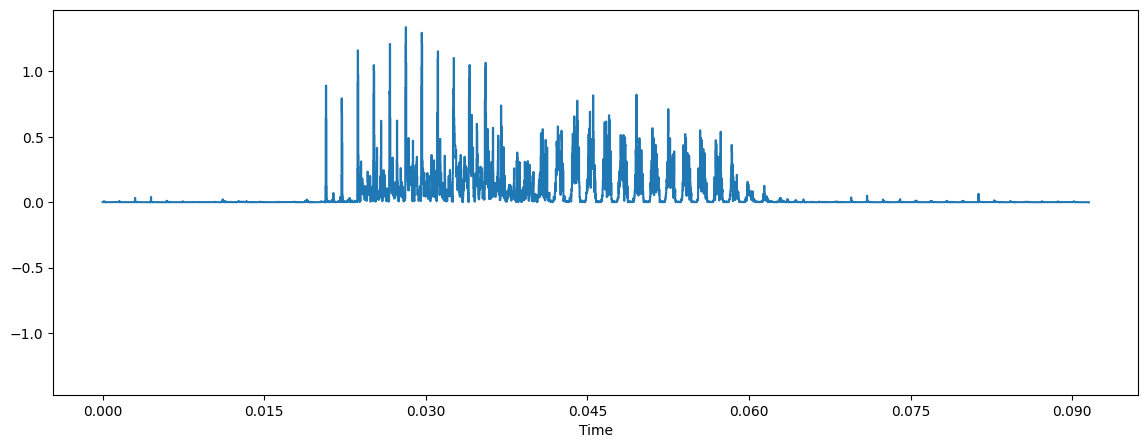

In [7]:
print("-----------------YES------------------")
plot_audiogram(X[yes_index])

-----------------NO------------------


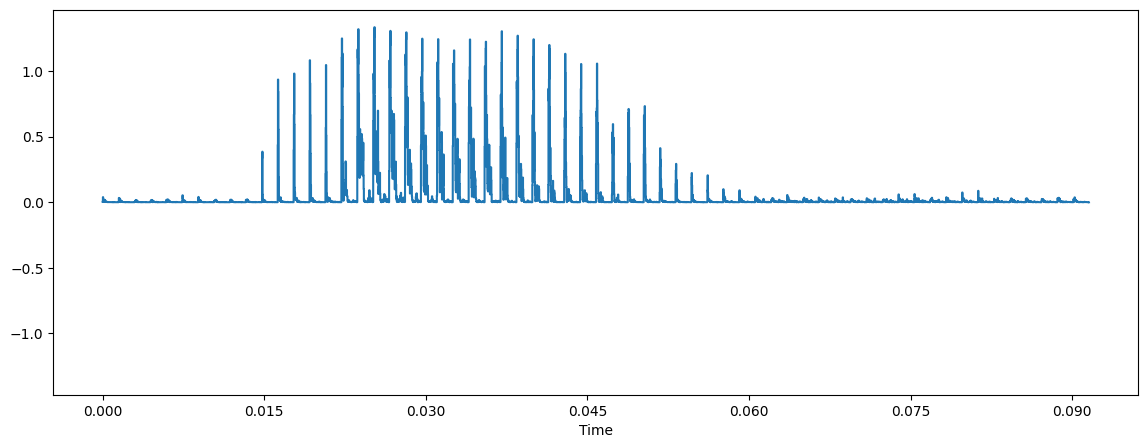

In [8]:
print("-----------------NO------------------")
plot_audiogram(X[no_index])

-----------------STOP------------------


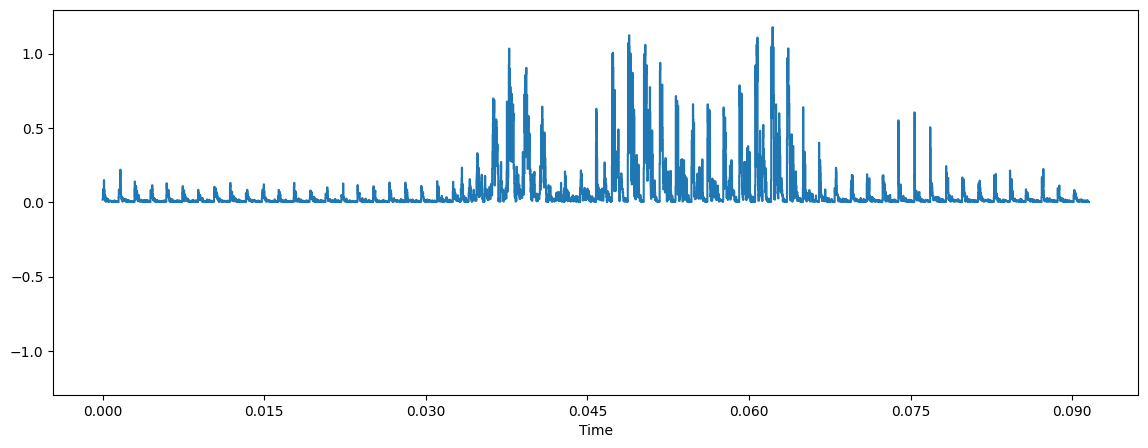

In [9]:
print("-----------------STOP------------------")
plot_audiogram(X[stop_index])

-----------------GO------------------


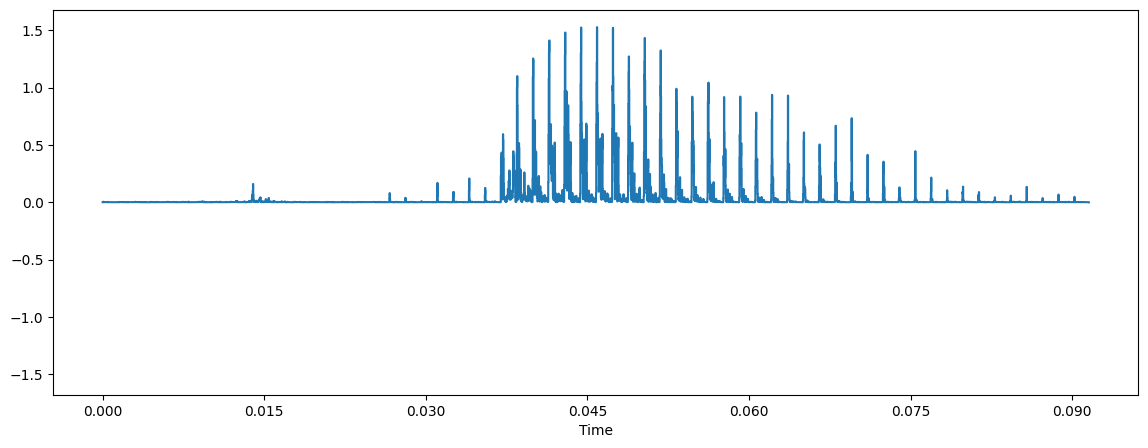

In [10]:
print("-----------------GO------------------")
plot_audiogram(X[go_index])

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

In [11]:
# Convolutional neural nework
seed(69)
tf.random.set_seed(69)

model = Sequential()
model.add(Conv2D(32, (5,5), activation = 'tanh', input_shape = X_train[0].shape)) 
model.add(MaxPooling2D(pool_size = (3,3))) #pooling layer
model.add(Flatten())
model.add(Dense(units = 4, activation = 'softmax')) #output layer

model.compile(loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, Y_train, epochs = 50, batch_size=500, validation_split = 0.2, verbose = 1)

CNN_predicted = model.predict(X_test)

Epoch 1/50
21/21 [==============================] - 11s 508ms/step - loss: 0.9468 - accuracy: 0.5915 - val_loss: 0.7820 - val_accuracy: 0.6704
Epoch 2/50
21/21 [==============================] - 10s 478ms/step - loss: 0.7632 - accuracy: 0.6859 - val_loss: 0.7220 - val_accuracy: 0.7081
Epoch 3/50
21/21 [==============================] - 10s 468ms/step - loss: 0.7036 - accuracy: 0.7284 - val_loss: 0.6748 - val_accuracy: 0.7280
Epoch 4/50
21/21 [==============================] - 9s 445ms/step - loss: 0.6597 - accuracy: 0.7416 - val_loss: 0.6238 - val_accuracy: 0.7502
Epoch 5/50
21/21 [==============================] - 10s 456ms/step - loss: 0.6325 - accuracy: 0.7507 - val_loss: 0.7245 - val_accuracy: 0.6966
Epoch 6/50
21/21 [==============================] - 10s 455ms/step - loss: 0.6103 - accuracy: 0.7610 - val_loss: 0.6951 - val_accuracy: 0.7113
Epoch 7/50
21/21 [==============================] - 10s 466ms/step - loss: 0.5868 - accuracy: 0.7703 - val_loss: 0.6791 - val_accuracy: 0.7153


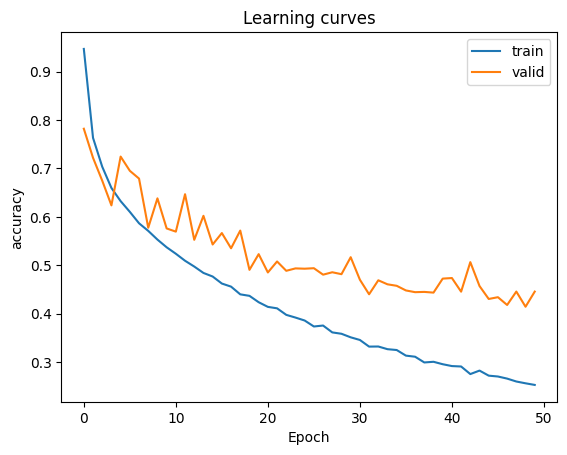

In [12]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [13]:
print("Accuracy on test data: {}".format(model.evaluate(X_test, Y_test)))

99/99 [==============================] - 1s 10ms/step - loss: 0.4402 - accuracy: 0.8405
Accuracy on test data: [0.4402415156364441, 0.8405336737632751]


In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train.reshape(-1, 62*65), Y_train)

kNN_y_pred = knn_model.fit(X_train.reshape(-1, 62*65), Y_train).predict(X_test.reshape(-1, 62*65)) 

In [15]:

print("KNN Model accuracy on the test data: {}".format(knn_model.score(X_test.reshape(-1, 62*65),Y_test)))
print("KNN Model accuracy on the train data: {}".format(knn_model.score(X_train.reshape(-1, 62*65),Y_train)))

KNN Model accuracy on the test data: 0.7665184243964421
KNN Model accuracy on the train data: 0.8430375724839145


**Do you think a neural network is suitable for this kind of problem? Why/why not?**

Neural networks are good for all kind of problems, especially for this one as we have pattern repeating data. There are patterns for this words that might appear closer to the start, middle of end of the recoding. That's why a convolutional neural network is even a better fit for this case rathern than a simple one. The accuracy speask to itself in this example when the question about suitability of neural networks appears here. nonetheless

__(d)__ Classify instances of the testing set using your models. Comment on the results in terms of metrics you have learned in the course.

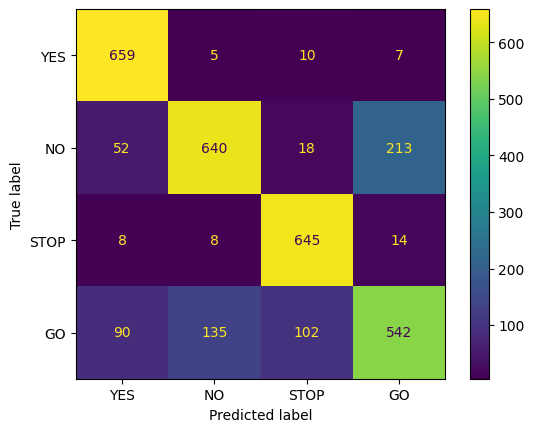

Accuracy measures how often the model is correct: 0.7897077509529861
Precision measures percentage of true positive: 0.7856124691468998
Sensitivity is good at understanding how well the model predicts something is positive: 0.7897077509529861
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.7833684535059415


In [17]:
words = np.array(['YES', 'NO', 'STOP', 'GO'])
actual = words[np.argmax(kNN_y_pred,axis = 1)]
predicted = words[np.argmax(Y_test,axis = 1)]

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['YES', 'NO', 'STOP', 'GO'])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))

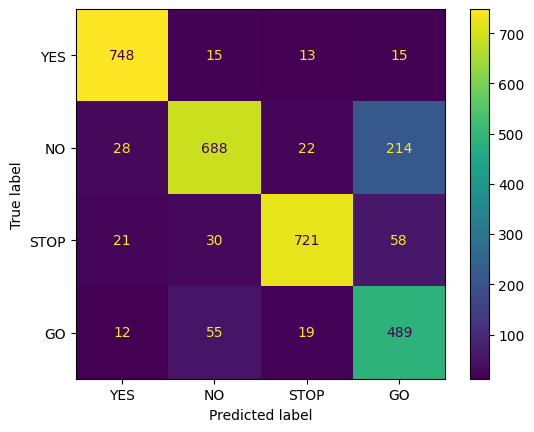

Accuracy measures how often the model is correct: 0.8405336721728082
Precision measures percentage of true positive: 0.8567508601873277
Sensitivity is good at understanding how well the model predicts something is positive: 0.8405336721728082
F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: 0.8431973844977259


In [18]:
# NEURAL NETWORK

words = np.array(['YES', 'NO', 'STOP', 'GO'])
actual = words[np.argmax(CNN_predicted,axis = 1)]
predicted = words[np.argmax(Y_test,axis = 1)]
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['YES', 'NO', 'STOP', 'GO'])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

##### Missclasified examples are similar to some extenst so it's not surprising that they are missclasified

In [19]:
missclasified = np.where(actual!=predicted)
missclasified

(array([  10,   12,   16,   26,   51,   52,   53,   54,   58,   61,   65,
          68,   69,   70,   75,   78,   81,   99,  125,  126,  129,  137,
         140,  151,  152,  154,  171,  192,  193,  194,  211,  214,  218,
         227,  236,  242,  243,  259,  266,  274,  280,  283,  285,  304,
         309,  313,  324,  326,  328,  339,  343,  349,  353,  356,  360,
         370,  374,  387,  394,  395,  400,  406,  415,  425,  426,  461,
         463,  465,  468,  469,  472,  478,  483,  494,  503,  505,  512,
         514,  543,  545,  548,  549,  553,  562,  568,  572,  575,  579,
         594,  603,  606,  617,  624,  626,  633,  641,  643,  658,  661,
         662,  664,  671,  674,  687,  697,  698,  709,  714,  721,  729,
         740,  744,  746,  753,  758,  778,  782,  786,  796,  799,  811,
         817,  828,  831,  833,  834,  838,  844,  861,  872,  873,  876,
         887,  889,  894,  912,  924,  935,  941,  965,  966,  969,  979,
         981,  993,  995,  996,  997, 

GO GO


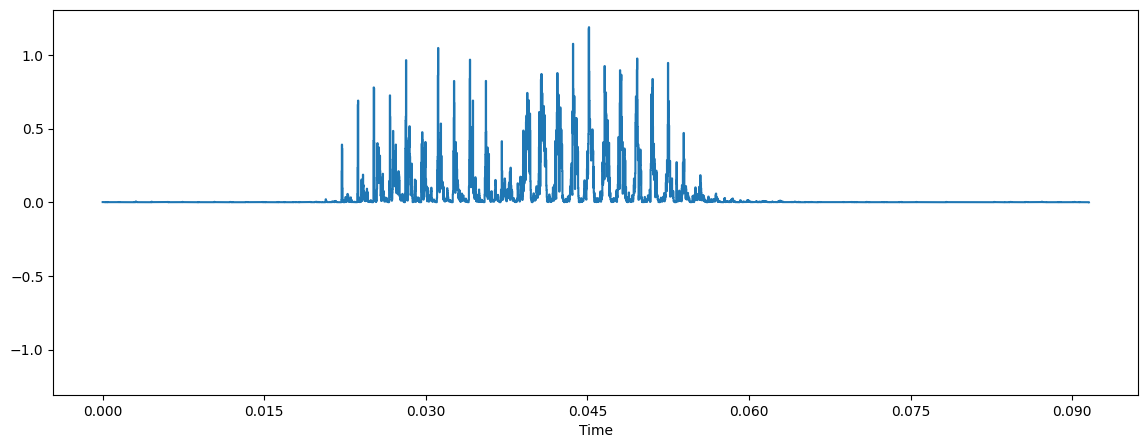

In [20]:
print(actual[8],predicted[8])
plot_audiogram(X[8])

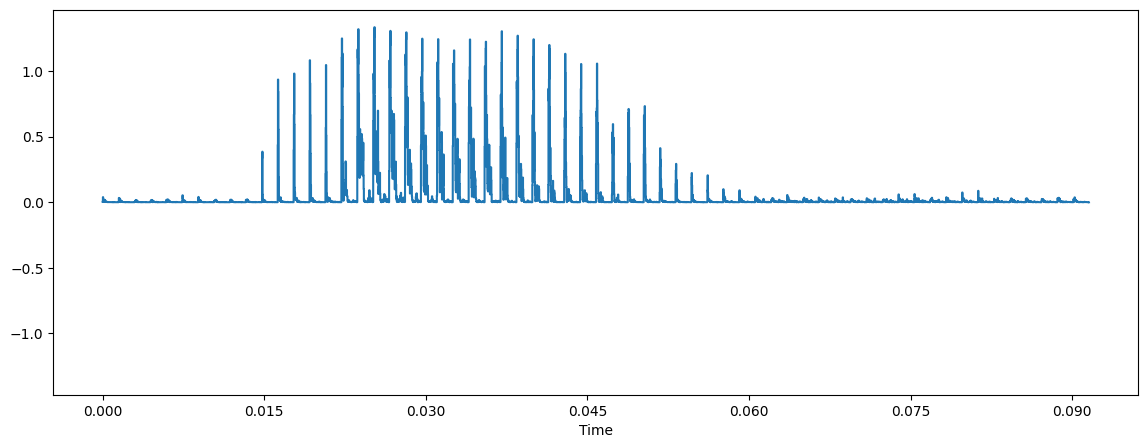

In [21]:
plot_audiogram(X[no_index])

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.